# Data evaluation of the questionnaire

Link to survey: https://forms.gle/TiY3p9WSkGV8mNKk6

In [6]:
# importing packages
import pandas as pd
#from lxml import etree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import requests
#import json
#import networkx as nx
#from networkx import Graph as NXGraph
#from rdflib import Graph as RDFGraph
#from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
#import statistics
#import collections
#import danker # https://github.com/athalhammer/danker
from scipy import stats
from scipy.stats import kstest
# https://www.statology.org/normality-test-python/
from urllib import parse
#from sklearn import linear_model

import mlnotify 
# https://github.com/aporia-ai/mlnotify
# Use %%notify at beginning of cell

import os.path, time
# Use %%time at beginning of cell

!python --version
print('------------')
print("Pandas " + pd.__version__)
print("Numpy " + np.__version__)
print("Seaborn " + sns.__version__)

Python 3.7.6
------------
Pandas 1.3.4
Numpy 1.18.1
Seaborn 0.11.2


In [7]:
# Load pre-queried (via queried web-interface) DBpedia categories
# https://dbpedia.org/sparql/

df_nineties_films = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_film90_impr.csv", sep=';')
df_actors = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_actors_impr.csv", sep=';')
df_music_genres = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_music_genres_impr.csv', sep=';', encoding='utf-8')
df_books = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_books_impr.csv", sep=';')
df_bookAut = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_authors_impr.csv", sep=';')
df_politicians = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_politicians_impr.csv", sep=';')
df_potus = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_potus_impr.csv', sep=';', encoding='utf-8')
df_cities = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_cities_impr.csv', sep=';', encoding='utf-8')
df_lakes = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_lakes_impr.csv", sep=';')
df_mountains = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/sv_mountains_prep.csv", sep=';')
df_european_capital_cities = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_european_capital_cities_impr.csv', sep=';', encoding='utf-8')
df_european_countries = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_european_countries_impr.csv', sep=';', encoding='utf-8')
df_asian_countries = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_asian_countries_impr.csv", sep=';')
df_continents = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_continents_impr.csv', sep=';', encoding='utf-8')
df_birds = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_birds_impr.csv', sep=';', encoding='utf-8')
df_african_animals = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_african_animals_impr.csv", sep=';')
df_furniture = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_furniture_impr.csv", sep=';')
df_vegetables = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_vegetables_impr.csv', sep=';', encoding='utf-8')
df_fastfood = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_fast_food_impr.csv", sep=';')
df_european_landmarks = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_european_landmarks_impr.csv", sep=';')
df_dax_companies = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_dax_companies_impr.csv", sep=';')
df_us_companies = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_us_companies_impr.csv', sep=';', encoding="ISO-8859-1") # different encoding due to special character (é)
df_us_tech_companies = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_us_tech_companies_impr.csv', sep=';', encoding='utf-8')

In [8]:
# Functions for splitting the URI to get resource/name (based of the URI)

def node_path(row):
    return parse.urlsplit(row['r_name']).path.split('/', 1)[-1]


def get_r_name(data_frame):
    helper_df = data_frame.copy()
    helper_df = helper_df.fillna('NaN')
    helper_df.replace(0, 'NaN', inplace=True)
    helper_df.insert(loc=0, column='r_name', value=helper_df['uri'])
    helper_df['r_name'] = helper_df.apply(lambda row: node_path(row), axis=1)
    helper_df['r_name'] = helper_df.apply(lambda row: node_path(row), axis=1)
    
    return helper_df

In [42]:
def plotCategory(data_frame, category_string):
    df_cat = get_r_name(data_frame)
    name_cat = category_string
    save_name = name_cat.replace(" ","_")

    
    df_cat['r_name'].value_counts().plot(kind="bar", figsize=(15,7)) #, color="#61d199")
    plt.ylabel('Distribution of survey mentions', fontsize=14,fontweight='bold', labelpad=15)
    plt.xlabel(name_cat, fontsize=14,fontweight='bold', labelpad=15)
    plt.tick_params(labelsize=14)
    plt.title(name_cat + " in the survey", size=18)
    plt.savefig("../plots/plots_survey/survey_"+save_name+".png", bbox_inches="tight")
    plt.show()
    

def plotCategoryThresh(data_frame, category_string, threshold_other=0.01):
    df_cat = get_r_name(data_frame)
    series_cat = pd.Series(df_cat['r_name'])
    name_cat = category_string
    save_name = name_cat.replace(" ","_")

    prob = series_cat.value_counts(normalize=True)
    #threshold = 0.01
    threshold = threshold_other
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['Other'] = tail_prob
    prob.plot(kind='bar', figsize=(15,7), color="#61d199")
    
    #plt.xticks(rotation=90)
    plt.ylabel('Distribution of survey mentions', fontsize=14,fontweight='bold', labelpad=15)
    plt.xlabel(name_cat, fontsize=14,fontweight='bold', labelpad=15)
    plt.tick_params(labelsize=14)
    #plt.title(name_cat + " in the survey", size=18)
    plt.savefig("../plots/plots_survey/survey_"+save_name+"_cut.png", bbox_inches="tight")
    plt.show()
    

def printStats(data_frame, category_string):
    df_cat = get_r_name(data_frame)
    df_stats = df_cat['r_name'].value_counts(normalize=True)
    name_cat = category_string
    #name_cat = data_frame.columns.values[0]


    print("Normal distribution: {}".format(name_cat))
    print('----------------------------------')
    print(stats.normaltest(df_stats))
    print(kstest(df_stats, 'norm'), '[Kolmogorov-Smirnov-Test]') # Kolmogorov-Smirnov-Test for normality
    print('===================================================================================================')
    print(df_stats)

    print('========================================')

    print("Dataframe shape is {}".format(df_stats.shape))
    print('----------------------------------------')
    print("df Kurtosis: %s" % stats.kurtosis(df_stats))
    print("df Skewness: %s" % stats.skew(df_stats))
    
def evaluateCat(data_frame, category_string, threshold=0.01):
    df_cat = data_frame
    name_cat = category_string
    threshold_other = threshold

    plotCategory(df_cat, category_string)
    plotCategoryThresh(df_cat, category_string, threshold_other)
    printStats(df_cat, category_string)

## 90s films

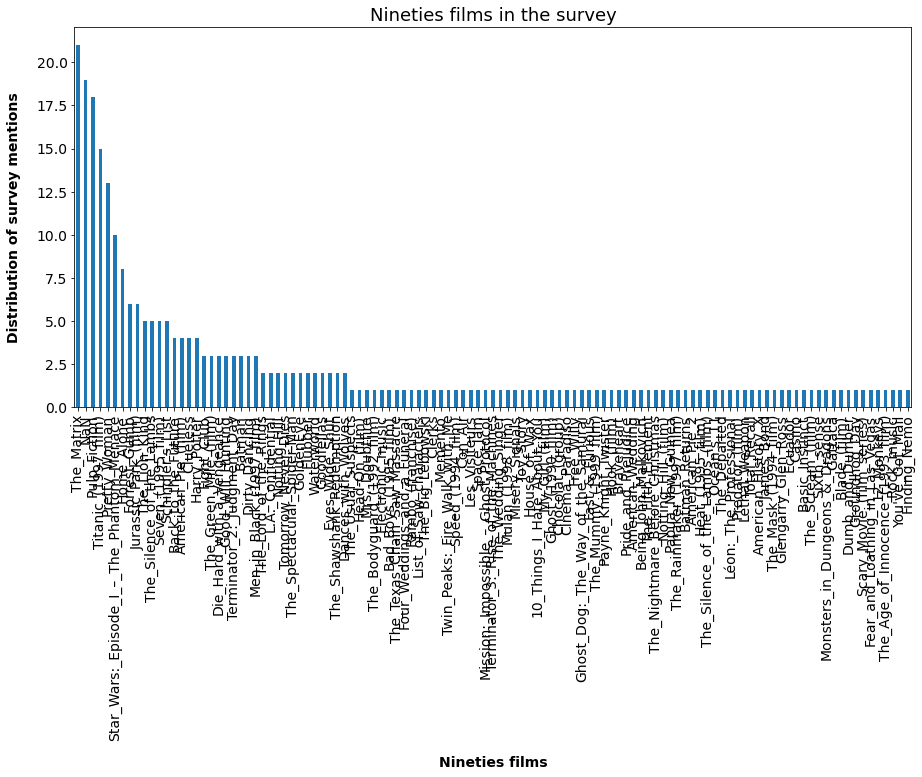

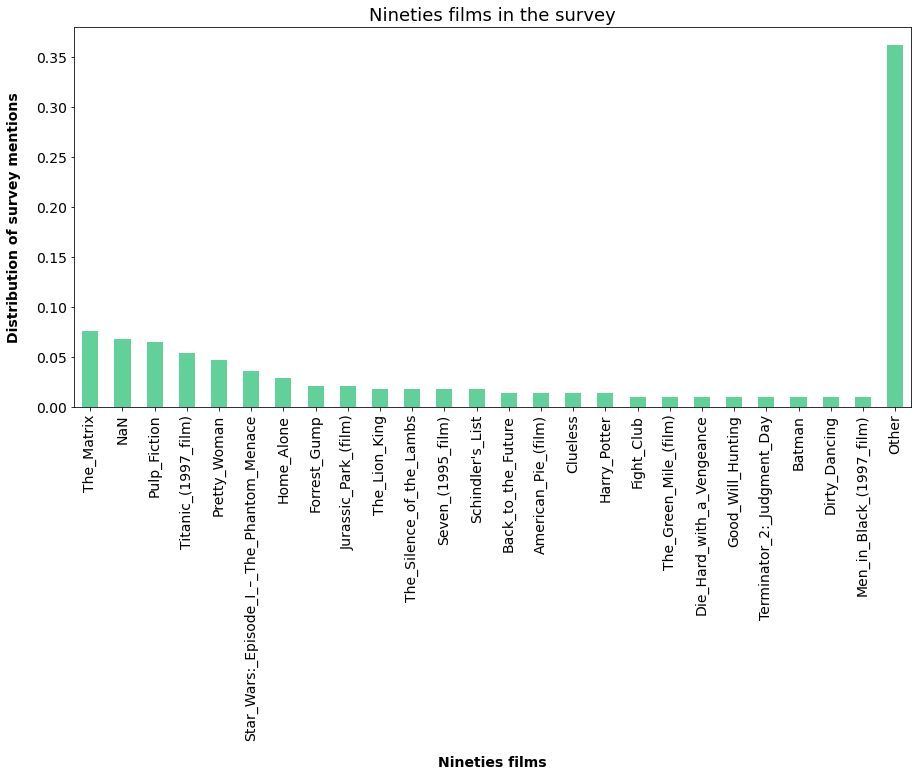

Normal distribution: Nineties films
----------------------------------
NormaltestResult(statistic=111.33627720800327, pvalue=6.662459567792343e-25)
KstestResult(statistic=0.5014454398824314, pvalue=8.249286361221548e-27) [Kolmogorov-Smirnov-Test]
The_Matrix                          0.076087
NaN                                 0.068841
Pulp_Fiction                        0.065217
Titanic_(1997_film)                 0.054348
Pretty_Woman                        0.047101
                                      ...   
12_Monkeys                          0.003623
The_Age_of_Innocence_(1993_film)    0.003623
Rock_music                          0.003623
You've_Got_Mail                     0.003623
Finding_Nemo                        0.003623
Name: r_name, Length: 113, dtype: float64
Dataframe shape is (113,)
----------------------------------------
df Kurtosis: 13.017310474860288
df Skewness: 3.572483416702789


In [16]:
evaluateCat(df_nineties_films, 'Nineties films')

## Actors

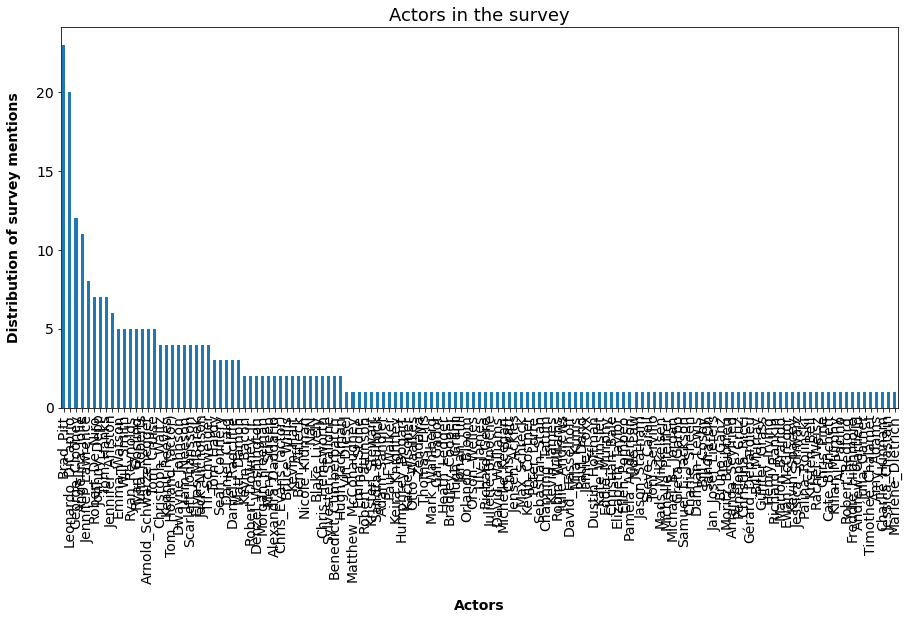

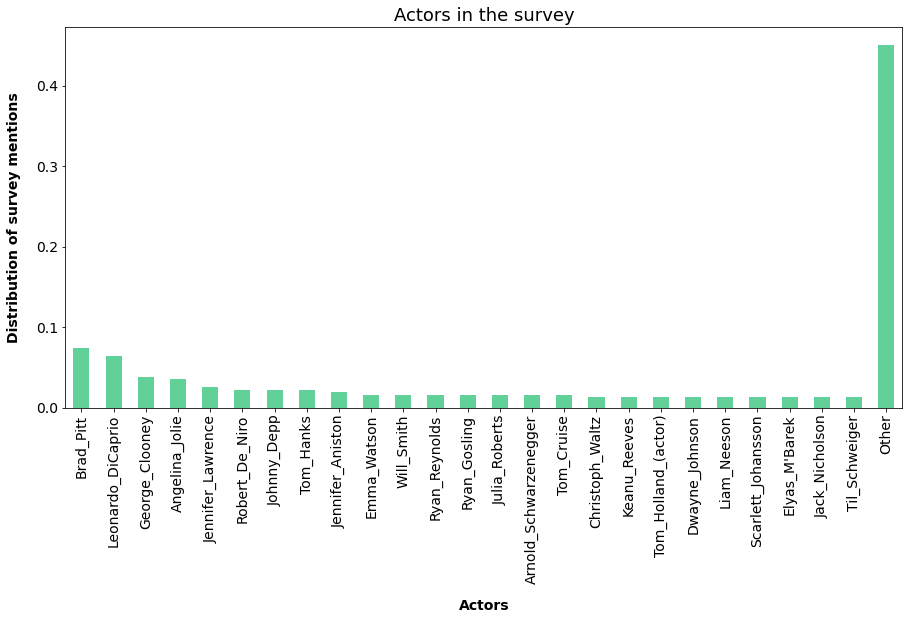

Normal distribution: Actors
----------------------------------
NormaltestResult(statistic=161.05881629654678, pvalue=1.0629734329413723e-35)
KstestResult(statistic=0.5012745738073946, pvalue=7.801889122831213e-33) [Kolmogorov-Smirnov-Test]
Brad_Pitt            0.073482
Leonardo_DiCaprio    0.063898
George_Clooney       0.038339
Angelina_Jolie       0.035144
Jennifer_Lawrence    0.025559
                       ...   
Timothée_Chalamet    0.003195
Amy_Adams            0.003195
Charlie_Hunnam       0.003195
Jessica_Chastain     0.003195
Marlene_Dietrich     0.003195
Name: r_name, Length: 139, dtype: float64
Dataframe shape is (139,)
----------------------------------------
df Kurtosis: 23.517004049116167
df Skewness: 4.400369990900614


In [17]:
evaluateCat(df_actors, 'Actors')

## Music genres

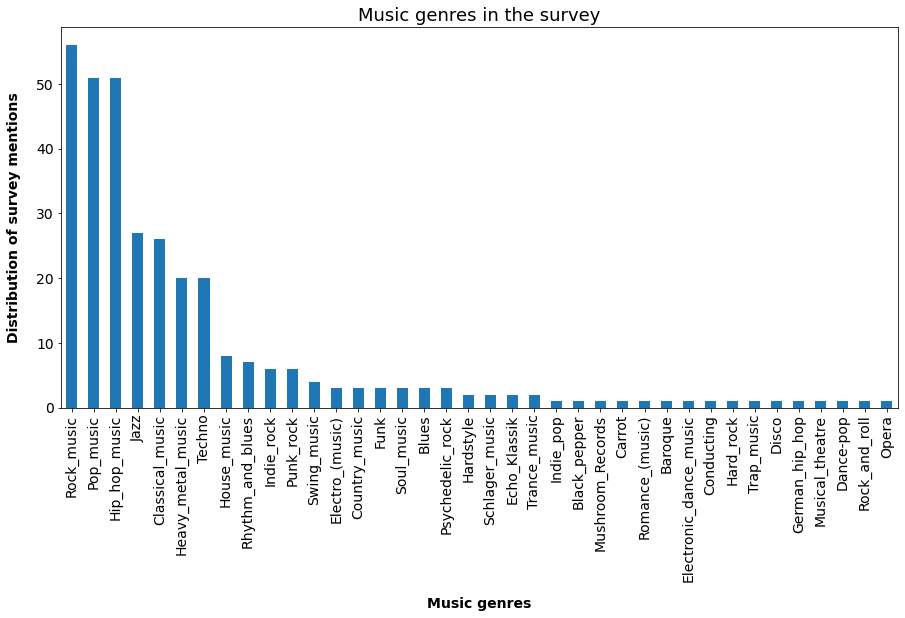

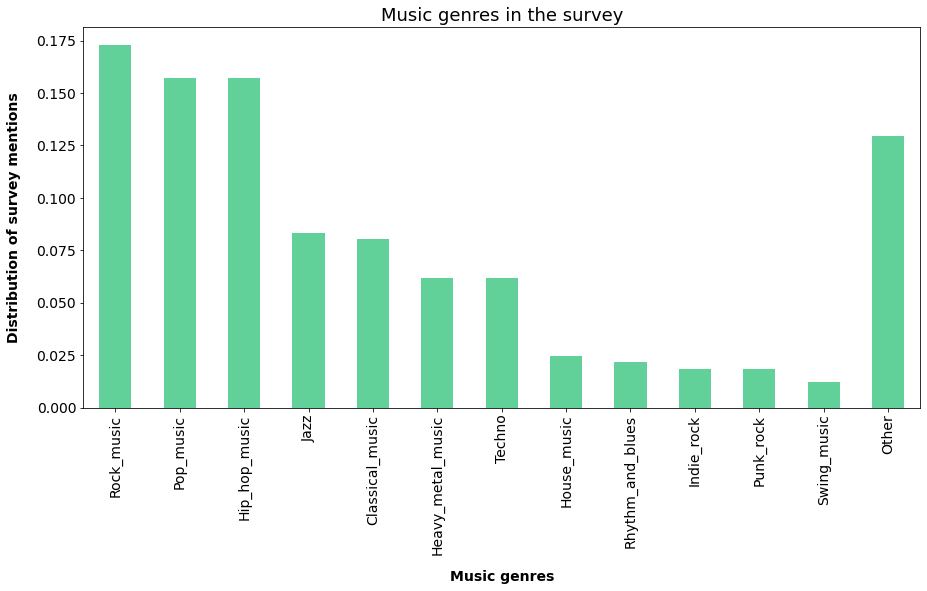

Normal distribution: Music genres
----------------------------------
NormaltestResult(statistic=30.78177280920643, pvalue=2.069297642074261e-07)
KstestResult(statistic=0.5012313013796785, pvalue=2.3463111070205733e-09) [Kolmogorov-Smirnov-Test]
Rock_music                0.172840
Pop_music                 0.157407
Hip_hop_music             0.157407
Jazz                      0.083333
Classical_music           0.080247
Heavy_metal_music         0.061728
Techno                    0.061728
House_music               0.024691
Rhythm_and_blues          0.021605
Indie_rock                0.018519
Punk_rock                 0.018519
Swing_music               0.012346
Electro_(music)           0.009259
Country_music             0.009259
Funk                      0.009259
Soul_music                0.009259
Blues                     0.009259
Psychedelic_rock          0.009259
Hardstyle                 0.006173
Schlager_music            0.006173
Echo_Klassik              0.006173
Trance_music        

In [18]:
evaluateCat(df_music_genres, 'Music genres')

## Books

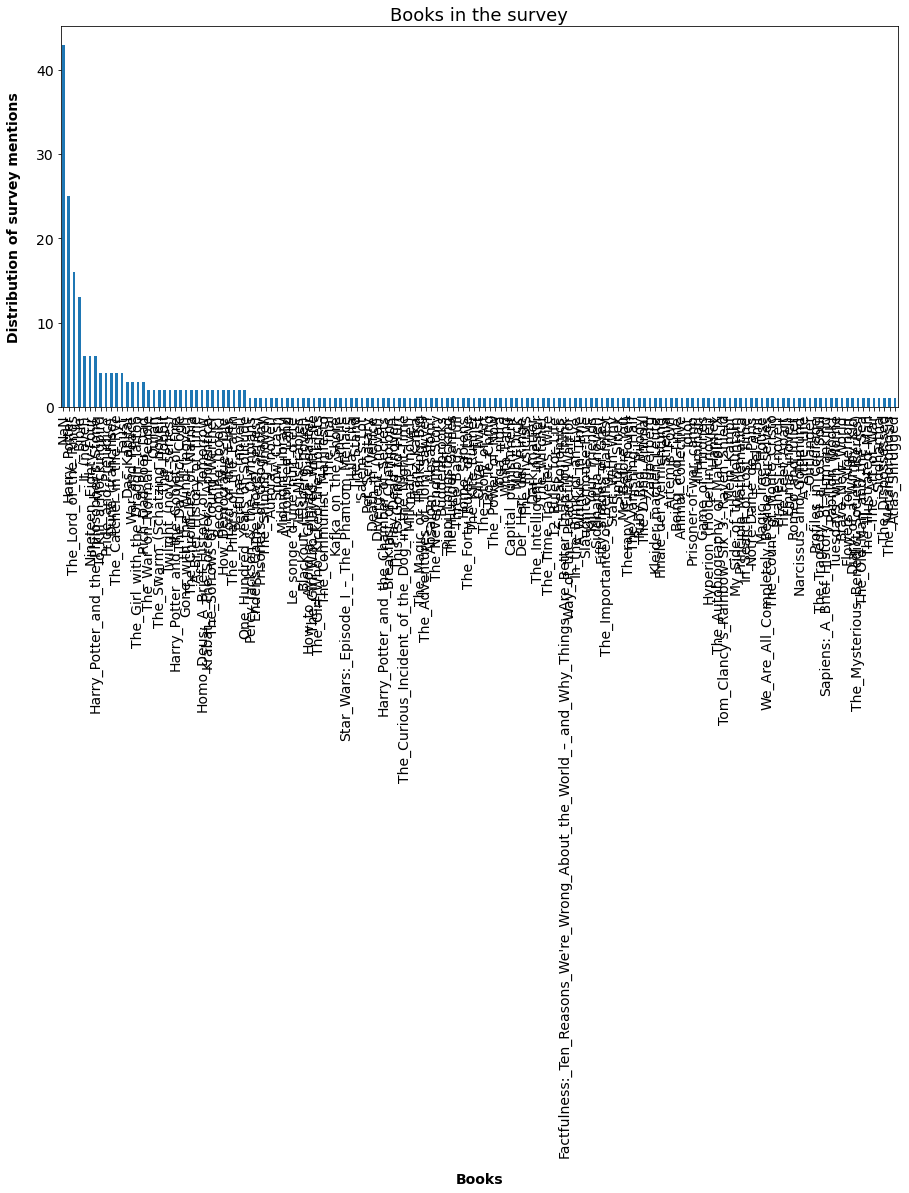

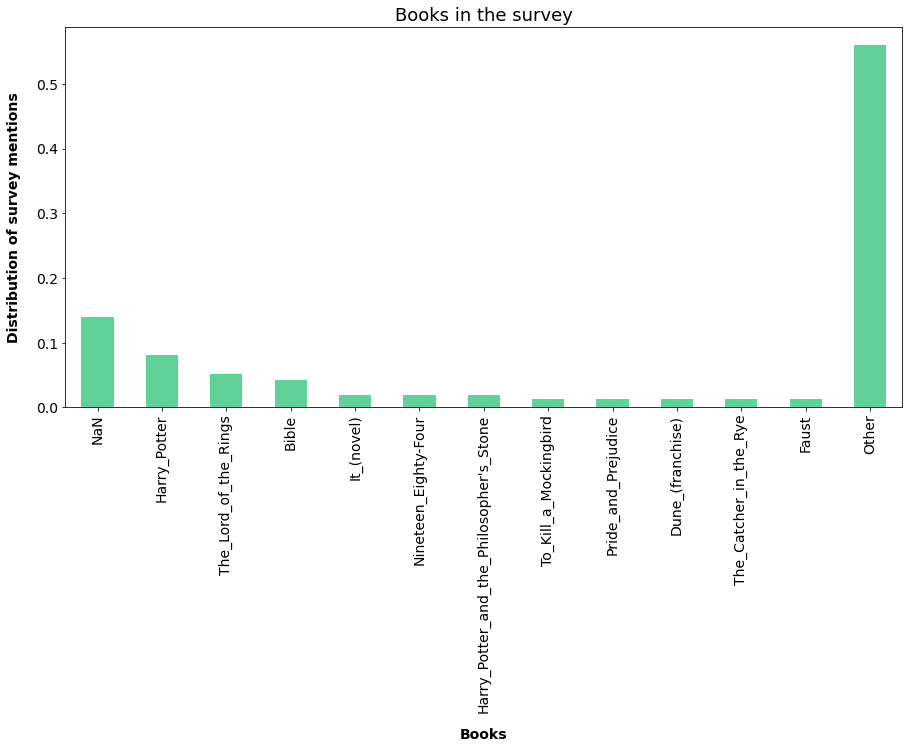

Normal distribution: Books
----------------------------------
NormaltestResult(statistic=259.852772522281, pvalue=3.747031923483975e-57)
KstestResult(statistic=0.5012994839574164, pvalue=5.062975234898229e-37) [Kolmogorov-Smirnov-Test]
NaN                      0.140065
Harry_Potter             0.081433
The_Lord_of_the_Rings    0.052117
Bible                    0.042345
It_(novel)               0.019544
                           ...   
The_Art_of_War           0.003257
Siddhartha               0.003257
The_Dispossessed         0.003257
The_Metamorphosis        0.003257
Atlas_Shrugged           0.003257
Name: r_name, Length: 157, dtype: float64
Dataframe shape is (157,)
----------------------------------------
df Kurtosis: 64.33931733093206
df Skewness: 7.561589579847789


In [19]:
evaluateCat(df_books, 'Books')

## Book authors

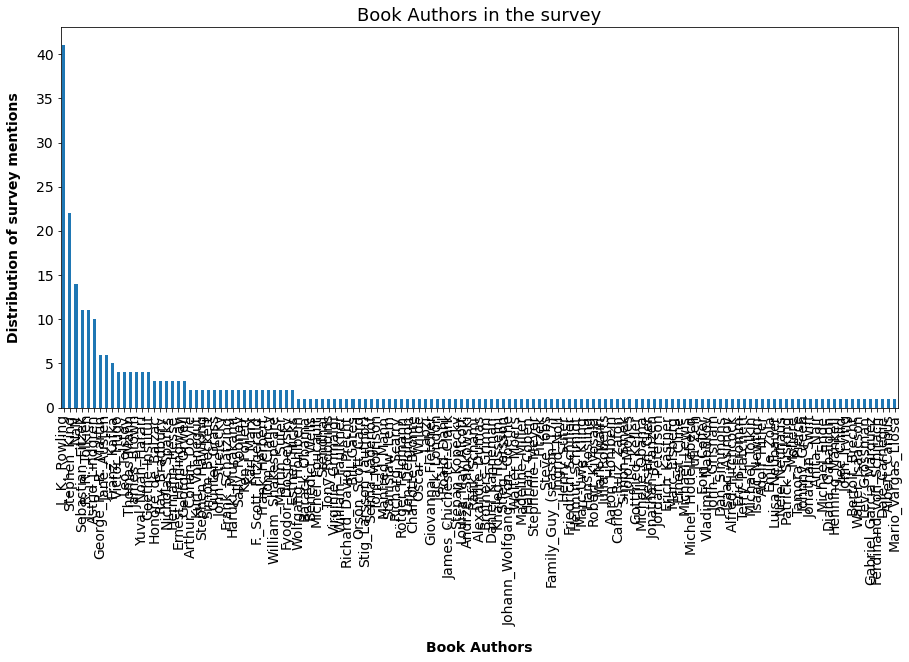

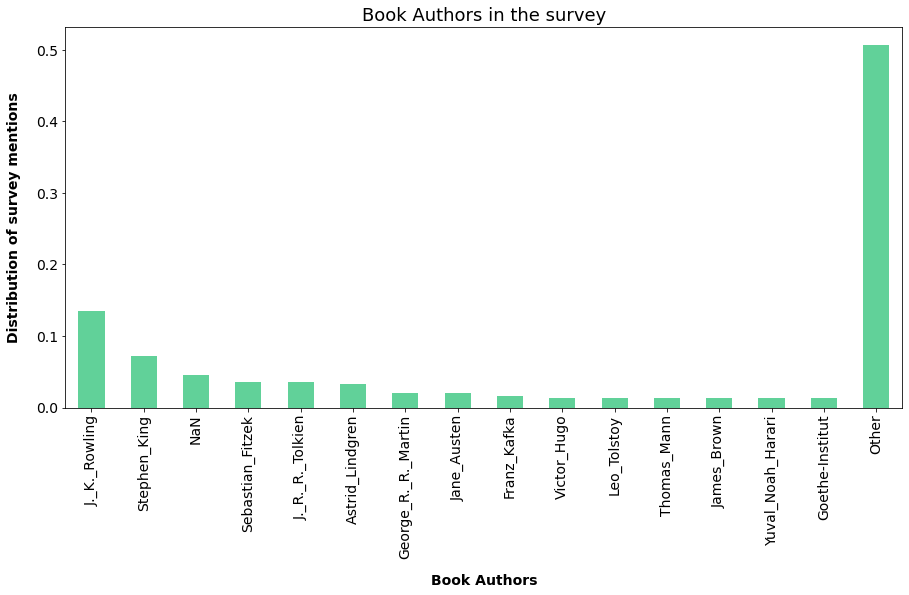

Normal distribution: Book Authors
----------------------------------
NormaltestResult(statistic=220.4893811171166, pvalue=1.3223281131575023e-48)
KstestResult(statistic=0.5013123077662314, pvalue=7.708744335543546e-33) [Kolmogorov-Smirnov-Test]
J._K._Rowling             0.134868
Stephen_King              0.072368
NaN                       0.046053
Sebastian_Fitzek          0.036184
J._R._R._Tolkien          0.036184
                            ...   
Gabriel_García_Márquez    0.003289
Ferdinand_von_Schirach    0.003289
Dale_Carnegie             0.003289
Albert_Camus              0.003289
Mario_Vargas_Llosa        0.003289
Name: r_name, Length: 139, dtype: float64
Dataframe shape is (139,)
----------------------------------------
df Kurtosis: 53.62408327886132
df Skewness: 6.751252992203358


In [20]:
evaluateCat(df_bookAut, 'Book Authors')

## Politicians

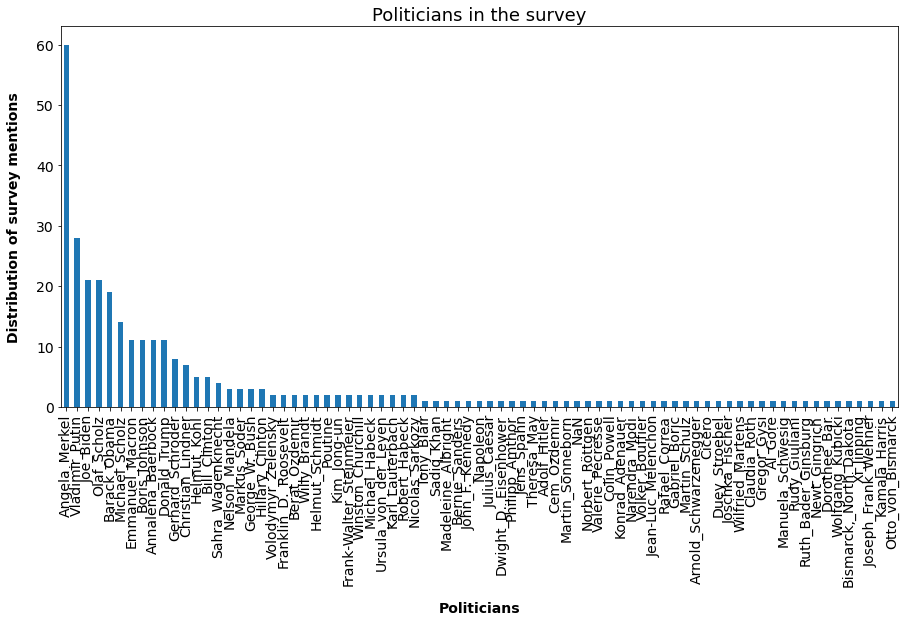

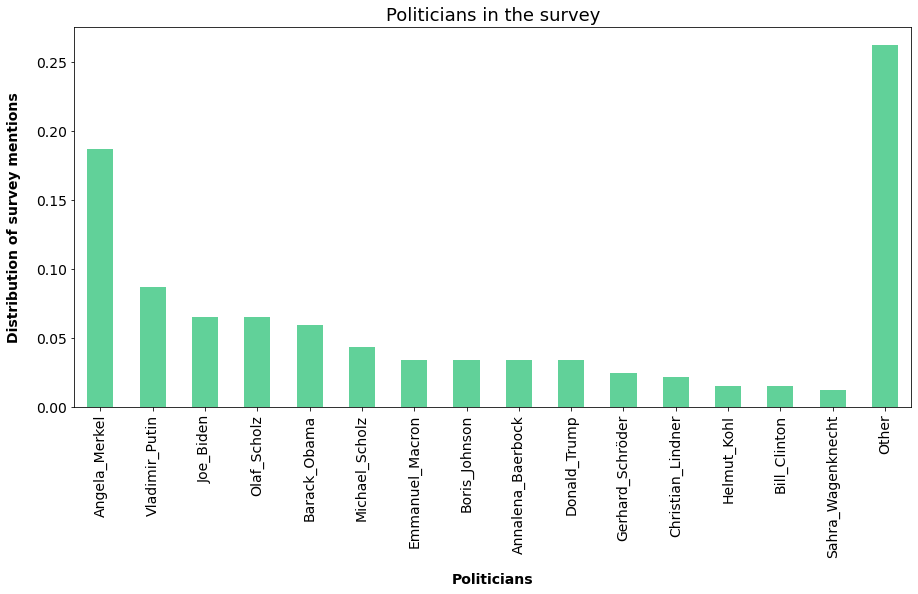

Normal distribution: Politicians
----------------------------------
NormaltestResult(statistic=109.43490787179445, pvalue=1.7238985002784664e-24)
KstestResult(statistic=0.5012466925971321, pvalue=2.0211717829349832e-18) [Kolmogorov-Smirnov-Test]
Angela_Merkel             0.187500
Vladimir_Putin            0.087500
Joe_Biden                 0.065625
Olaf_Scholz               0.065625
Barack_Obama              0.059375
                            ...   
Bismarck,_North_Dakota    0.003125
Xi_Jinping                0.003125
Joseph_Frank_Wehner       0.003125
Kamala_Harris             0.003125
Otto_von_Bismarck         0.003125
Name: r_name, Length: 77, dtype: float64
Dataframe shape is (77,)
----------------------------------------
df Kurtosis: 25.26714789607494
df Skewness: 4.588837196018164


In [21]:
evaluateCat(df_politicians, 'Politicians')

## Potus

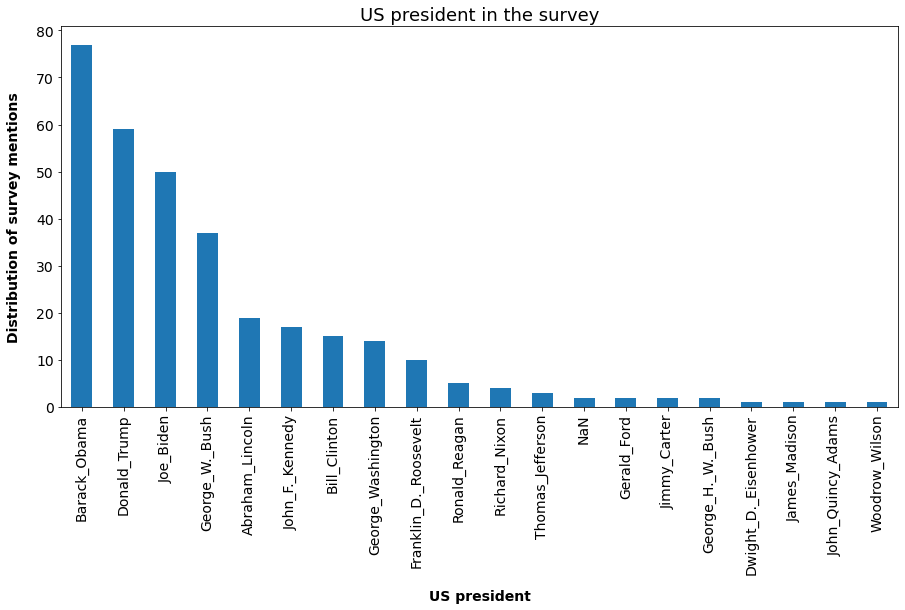

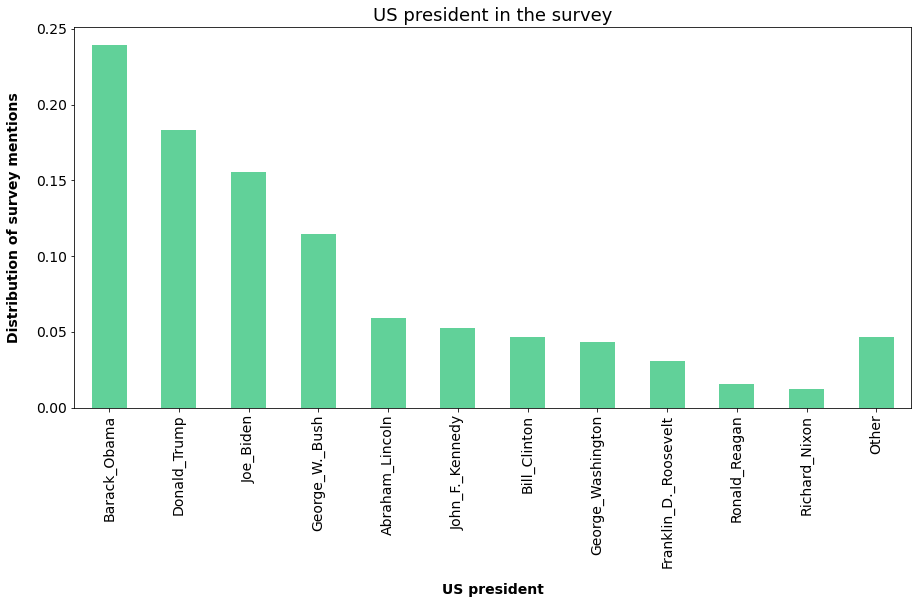

Normal distribution: US president
----------------------------------
NormaltestResult(statistic=12.36972131055416, pvalue=0.002060388636916604)
KstestResult(statistic=0.5012389491898238, pvalue=3.578208014727658e-05) [Kolmogorov-Smirnov-Test]
Barack_Obama             0.239130
Donald_Trump             0.183230
Joe_Biden                0.155280
George_W._Bush           0.114907
Abraham_Lincoln          0.059006
John_F._Kennedy          0.052795
Bill_Clinton             0.046584
George_Washington        0.043478
Franklin_D._Roosevelt    0.031056
Ronald_Reagan            0.015528
Richard_Nixon            0.012422
Thomas_Jefferson         0.009317
NaN                      0.006211
Gerald_Ford              0.006211
Jimmy_Carter             0.006211
George_H._W._Bush        0.006211
Dwight_D._Eisenhower     0.003106
James_Madison            0.003106
John_Quincy_Adams        0.003106
Woodrow_Wilson           0.003106
Name: r_name, dtype: float64
Dataframe shape is (20,)
-----------------------

In [22]:
evaluateCat(df_potus, 'US president')

## Cities

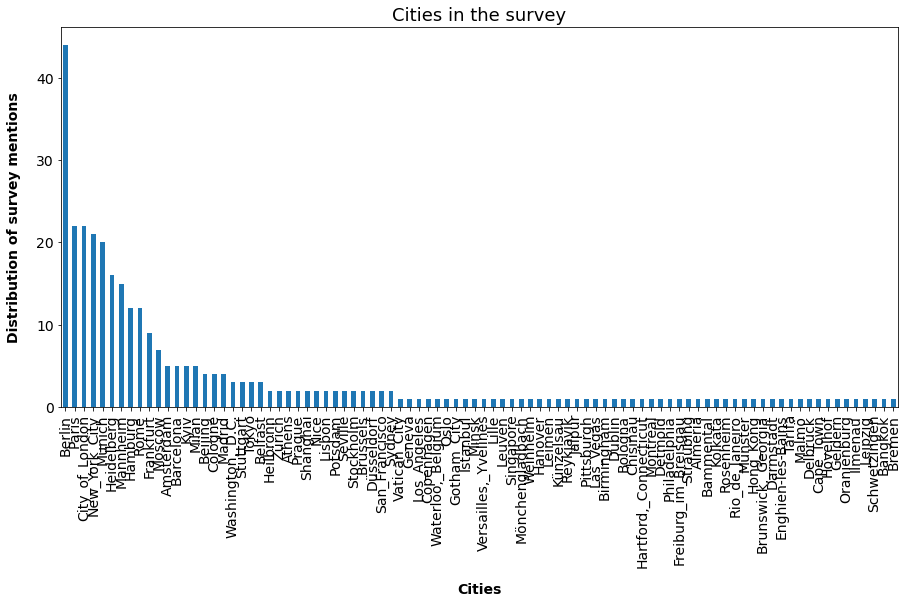

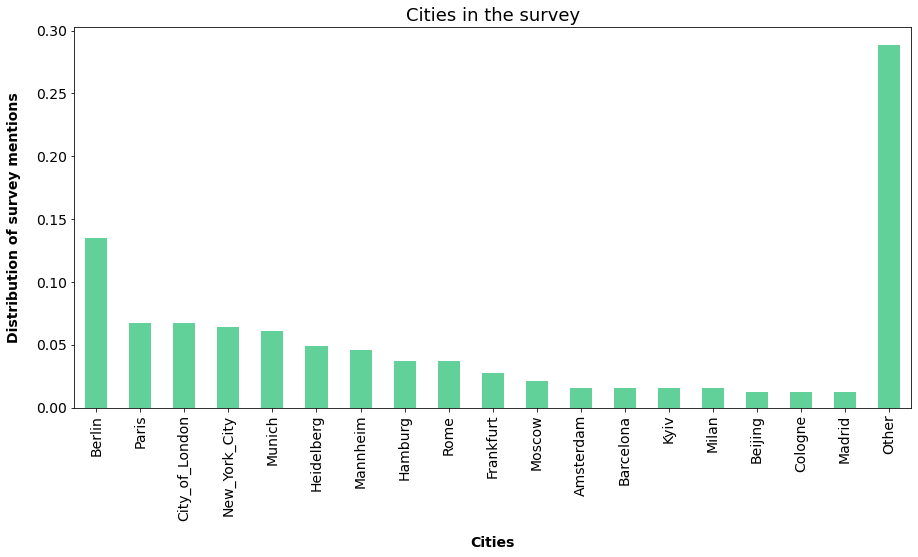

Normal distribution: Cities
----------------------------------
NormaltestResult(statistic=102.10370216253452, pvalue=6.736941628306416e-23)
KstestResult(statistic=0.5012237474072503, pvalue=1.933265110353738e-21) [Kolmogorov-Smirnov-Test]
Berlin            0.134969
Paris             0.067485
City_of_London    0.067485
New_York_City     0.064417
Munich            0.061350
                    ...   
Ilmenau           0.003067
Leipzig           0.003067
Schwetzingen      0.003067
Bangkok           0.003067
Bremen            0.003067
Name: r_name, Length: 90, dtype: float64
Dataframe shape is (90,)
----------------------------------------
df Kurtosis: 16.784202609572052
df Skewness: 3.773397217212655


In [23]:
evaluateCat(df_cities, 'Cities')

## Lakes

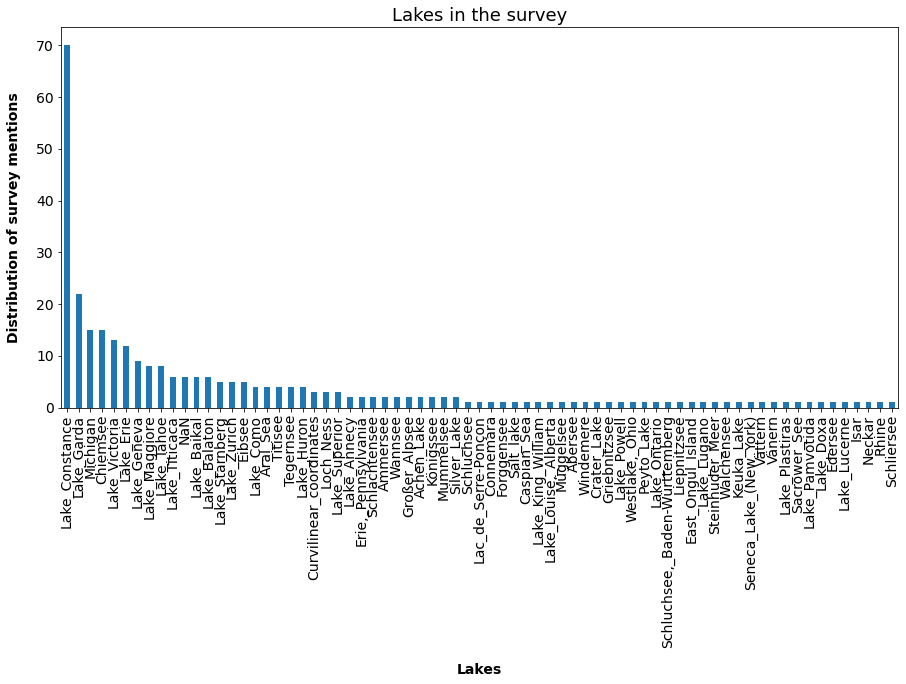

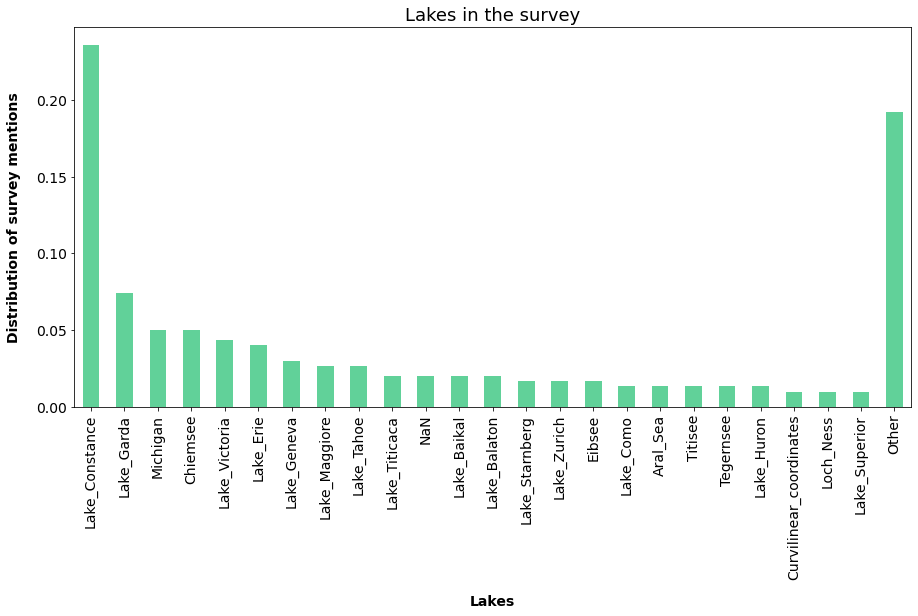

Normal distribution: Lakes
----------------------------------
NormaltestResult(statistic=127.42342094796093, pvalue=2.1397139028786637e-28)
KstestResult(statistic=0.5013432374633685, pvalue=4.934708578353226e-17) [Kolmogorov-Smirnov-Test]
Lake_Constance    0.235690
Lake_Garda        0.074074
Michigan          0.050505
Chiemsee          0.050505
Lake_Victoria     0.043771
                    ...   
Lake_Lucerne      0.003367
Isar              0.003367
Neckar            0.003367
Rhine             0.003367
Schliersee        0.003367
Name: r_name, Length: 71, dtype: float64
Dataframe shape is (71,)
----------------------------------------
df Kurtosis: 41.11214921579017
df Skewness: 6.033774152170241


In [24]:
evaluateCat(df_lakes, 'Lakes')

## Mountains

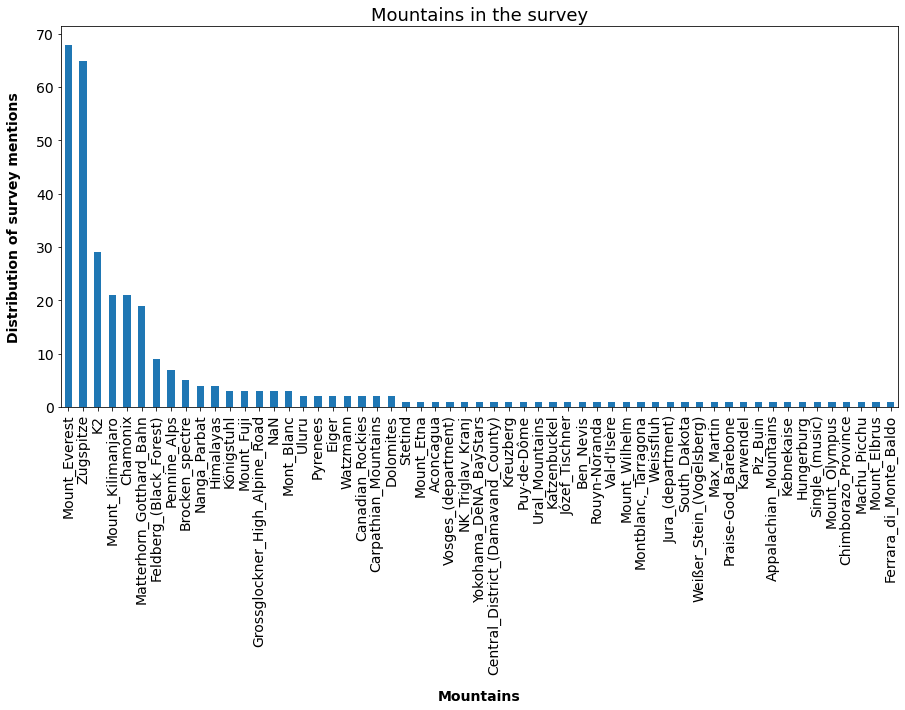

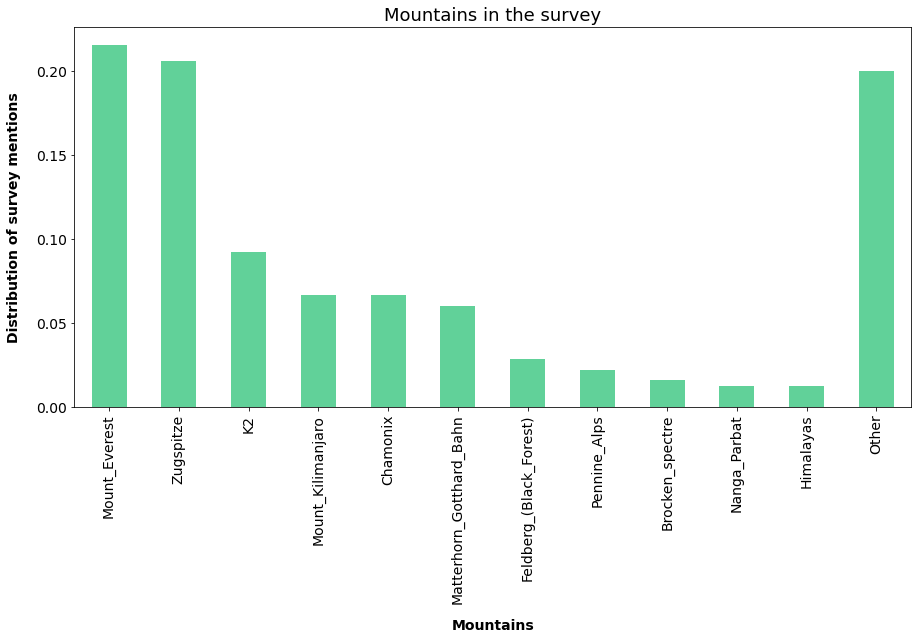

Normal distribution: Mountains
----------------------------------
NormaltestResult(statistic=75.86940254502514, pvalue=3.3509547605689596e-17)
KstestResult(statistic=0.5012664813025568, pvalue=8.969287386754442e-14) [Kolmogorov-Smirnov-Test]
Mount_Everest                         0.215873
Zugspitze                             0.206349
K2                                    0.092063
Mount_Kilimanjaro                     0.066667
Chamonix                              0.066667
Matterhorn_Gotthard_Bahn              0.060317
Feldberg_(Black_Forest)               0.028571
Pennine_Alps                          0.022222
Brocken_spectre                       0.015873
Nanga_Parbat                          0.012698
Himalayas                             0.012698
Königstuhl                            0.009524
Mount_Fuji                            0.009524
Grossglockner_High_Alpine_Road        0.009524
NaN                                   0.009524
Mont_Blanc                            0.009524
Uluru 

In [25]:
evaluateCat(df_mountains, 'Mountains')

## European capital cities

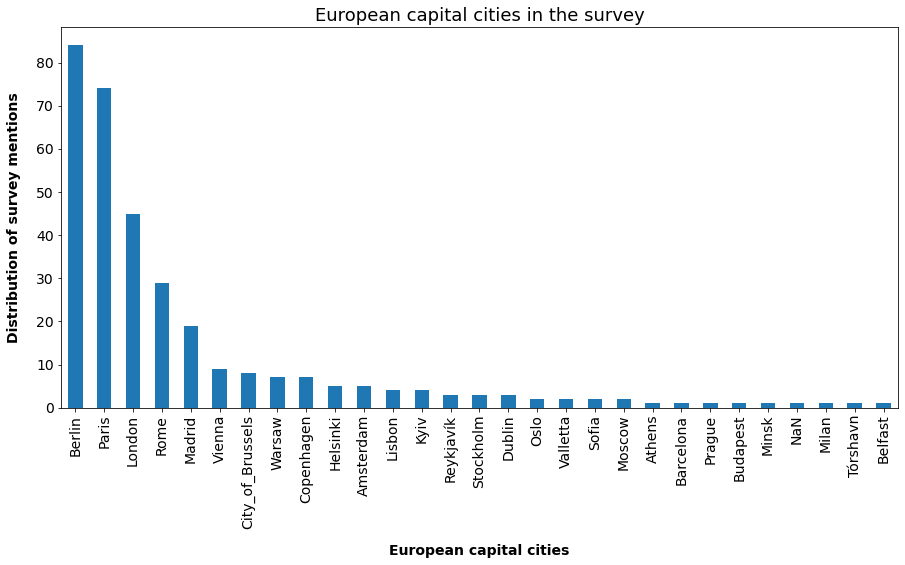

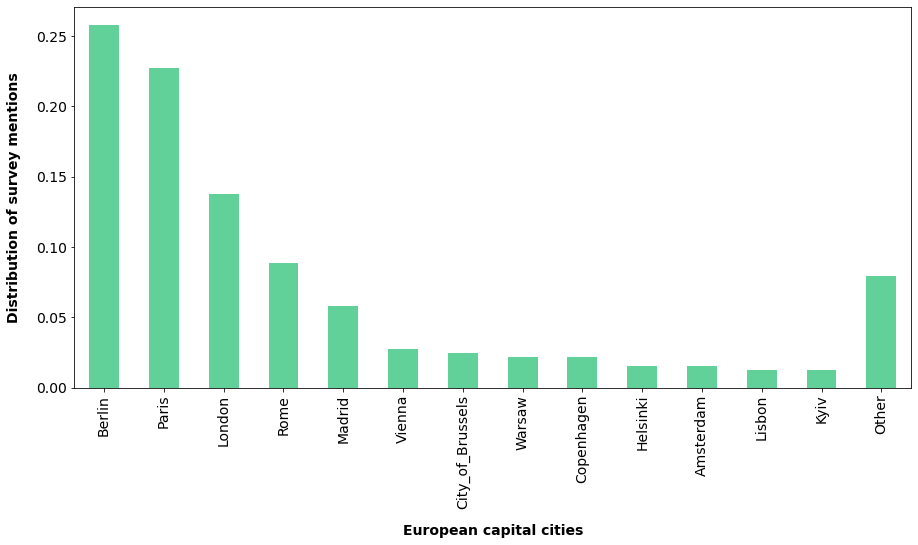

Normal distribution: European capital cities
----------------------------------
NormaltestResult(statistic=32.53383541796921, pvalue=8.617224378486453e-08)
KstestResult(statistic=0.5012237474072503, pvalue=2.899158356948321e-07) [Kolmogorov-Smirnov-Test]
Berlin              0.257669
Paris               0.226994
London              0.138037
Rome                0.088957
Madrid              0.058282
Vienna              0.027607
City_of_Brussels    0.024540
Warsaw              0.021472
Copenhagen          0.021472
Helsinki            0.015337
Amsterdam           0.015337
Lisbon              0.012270
Kyiv                0.012270
Reykjavík           0.009202
Stockholm           0.009202
Dublin              0.009202
Oslo                0.006135
Valletta            0.006135
Sofia               0.006135
Moscow              0.006135
Athens              0.003067
Barcelona           0.003067
Prague              0.003067
Budapest            0.003067
Minsk               0.003067
NaN                 

In [44]:
evaluateCat(df_european_capital_cities, 'European capital cities')

## European countries

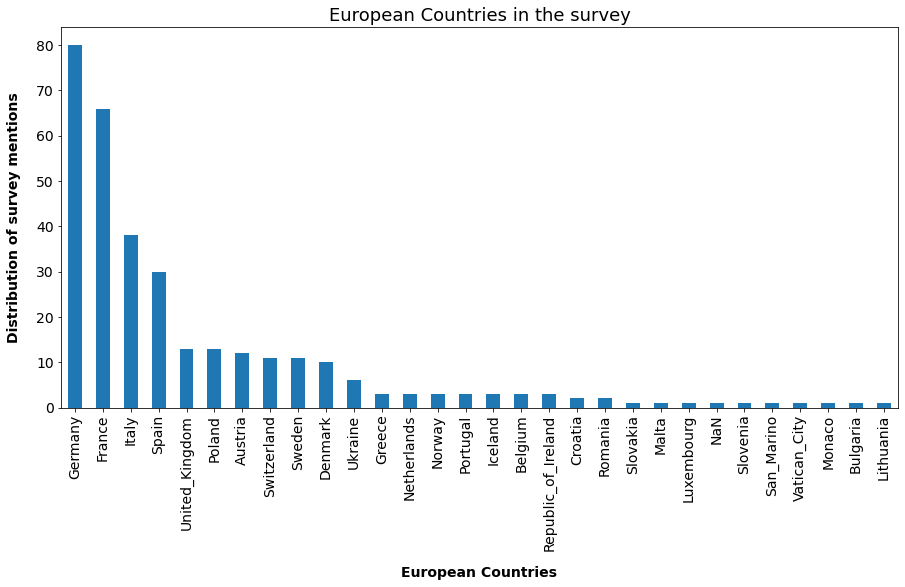

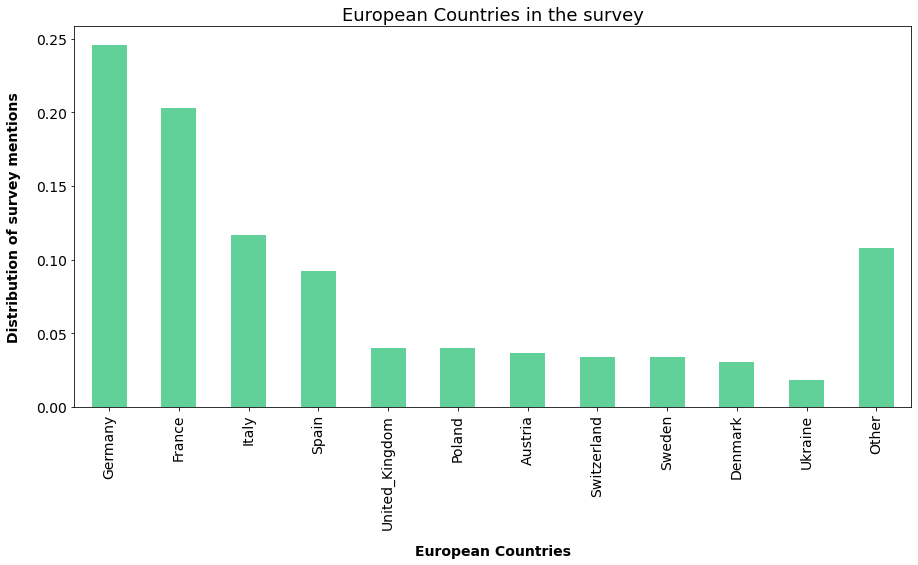

Normal distribution: European Countries
----------------------------------
NormaltestResult(statistic=34.27436418555041, pvalue=3.6092451515150084e-08)
KstestResult(statistic=0.5012275127720234, pvalue=1.697290232324343e-07) [Kolmogorov-Smirnov-Test]
Germany                0.246154
France                 0.203077
Italy                  0.116923
Spain                  0.092308
United_Kingdom         0.040000
Poland                 0.040000
Austria                0.036923
Switzerland            0.033846
Sweden                 0.033846
Denmark                0.030769
Ukraine                0.018462
Greece                 0.009231
Netherlands            0.009231
Norway                 0.009231
Portugal               0.009231
Iceland                0.009231
Belgium                0.009231
Republic_of_Ireland    0.009231
Croatia                0.006154
Romania                0.006154
Slovakia               0.003077
Malta                  0.003077
Luxembourg             0.003077
NaN          

In [27]:
evaluateCat(df_european_countries, 'European Countries')

## Asian countries

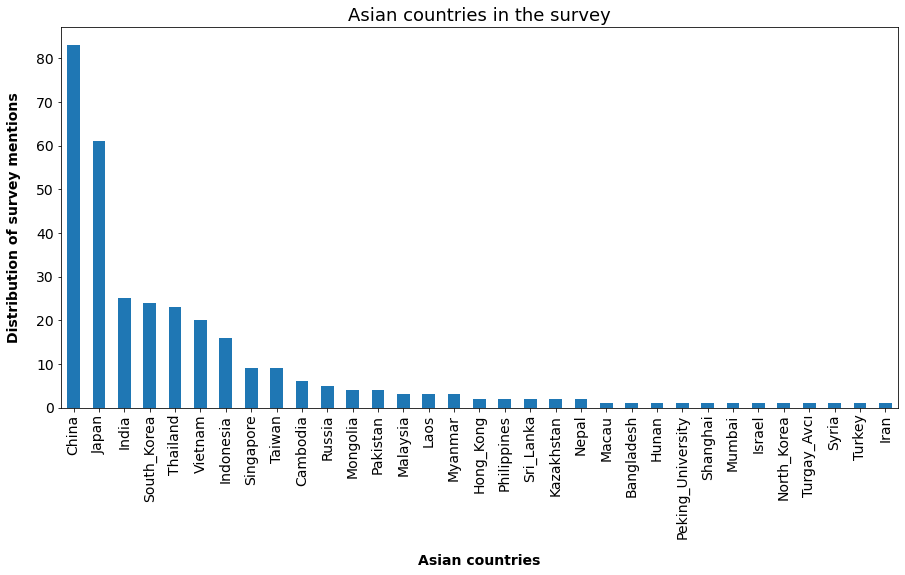

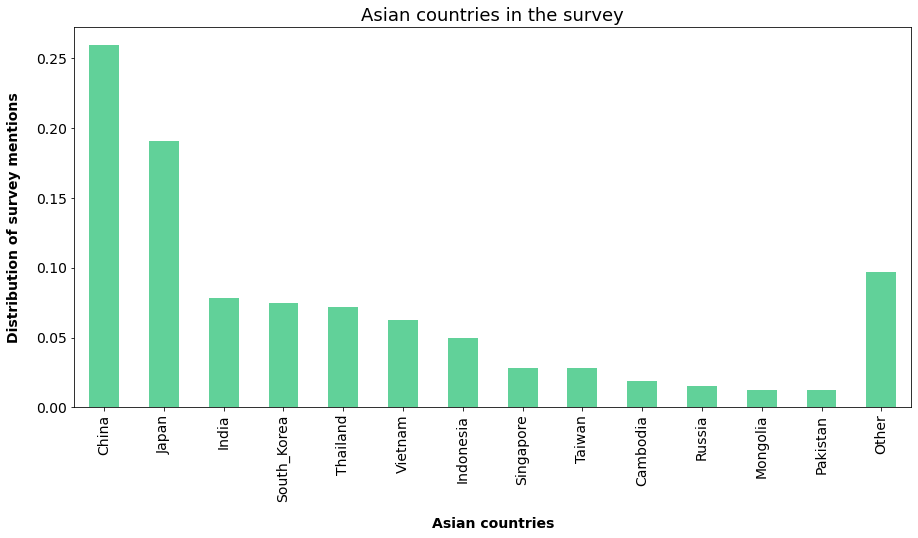

Normal distribution: Asian countries
----------------------------------
NormaltestResult(statistic=42.72704998979904, pvalue=5.271557897234424e-10)
KstestResult(statistic=0.5012466925971321, pvalue=3.4033763190945135e-08) [Kolmogorov-Smirnov-Test]
China                0.259375
Japan                0.190625
India                0.078125
South_Korea          0.075000
Thailand             0.071875
Vietnam              0.062500
Indonesia            0.050000
Singapore            0.028125
Taiwan               0.028125
Cambodia             0.018750
Russia               0.015625
Mongolia             0.012500
Pakistan             0.012500
Malaysia             0.009375
Laos                 0.009375
Myanmar              0.009375
Hong_Kong            0.006250
Philippines          0.006250
Sri_Lanka            0.006250
Kazakhstan           0.006250
Nepal                0.006250
Macau                0.003125
Bangladesh           0.003125
Hunan                0.003125
Peking_University    0.003125
Sh

In [28]:
evaluateCat(df_asian_countries, 'Asian countries')

## Continents

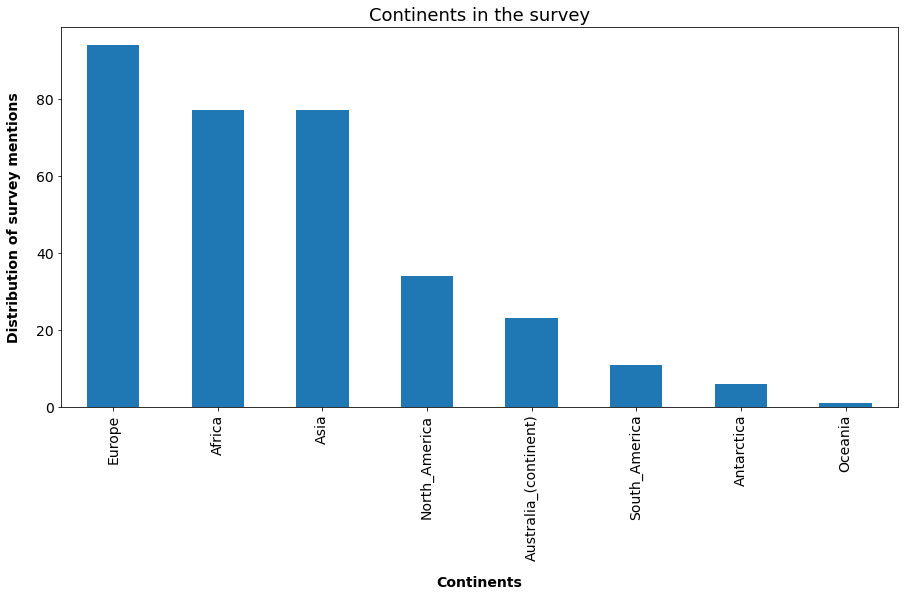

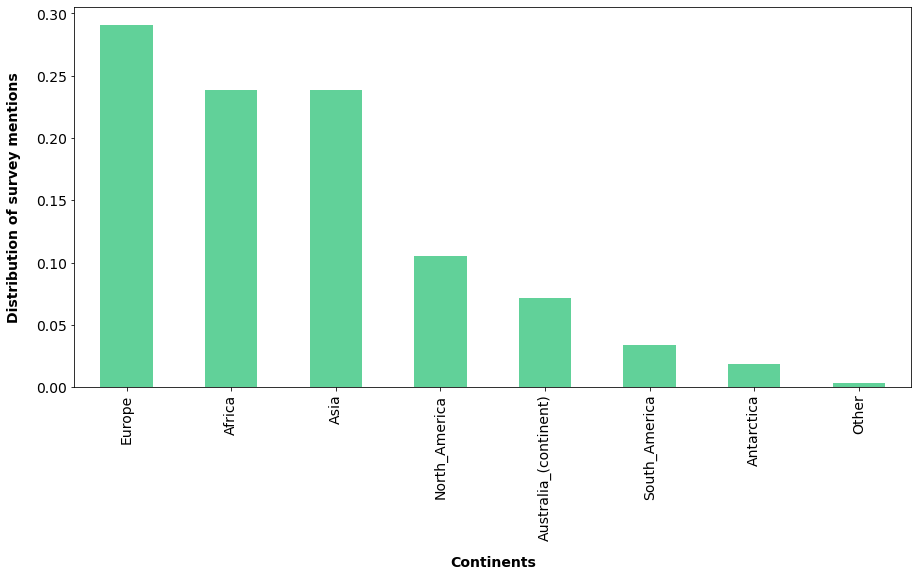

Normal distribution: Continents
----------------------------------
NormaltestResult(statistic=2.639013544856365, pvalue=0.26726709296099016)
KstestResult(statistic=0.5012351134460925, pvalue=0.02208088044736244) [Kolmogorov-Smirnov-Test]
Europe                   0.291022
Africa                   0.238390
Asia                     0.238390
North_America            0.105263
Australia_(continent)    0.071207
South_America            0.034056
Antarctica               0.018576
Oceania                  0.003096
Name: r_name, dtype: float64
Dataframe shape is (8,)
----------------------------------------
df Kurtosis: -1.5356529613795369
df Skewness: 0.36662937718102623


In [47]:
evaluateCat(df_continents, 'Continents')

## Birds

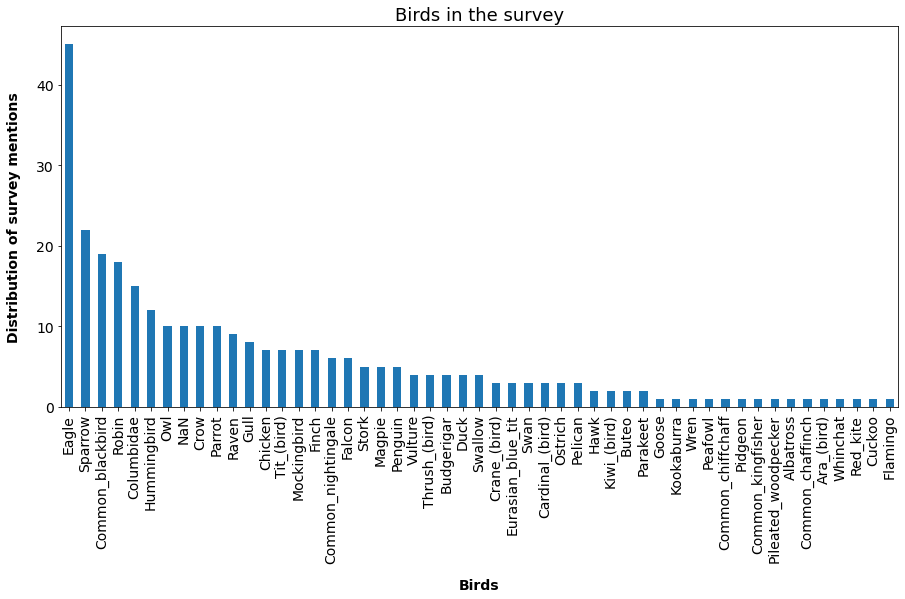

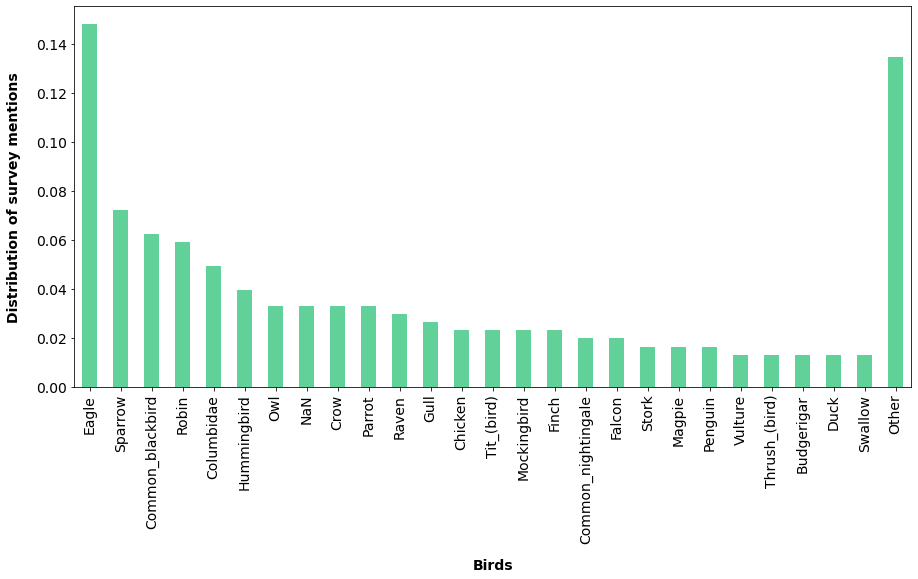

Normal distribution: Birds
----------------------------------
NormaltestResult(statistic=61.93036754273747, pvalue=3.5644420380382285e-14)
KstestResult(statistic=0.5013123077662314, pvalue=2.2133057775080572e-12) [Kolmogorov-Smirnov-Test]
Eagle                  0.148026
Sparrow                0.072368
Common_blackbird       0.062500
Robin                  0.059211
Columbidae             0.049342
Hummingbird            0.039474
Owl                    0.032895
NaN                    0.032895
Crow                   0.032895
Parrot                 0.032895
Raven                  0.029605
Gull                   0.026316
Chicken                0.023026
Tit_(bird)             0.023026
Mockingbird            0.023026
Finch                  0.023026
Common_nightingale     0.019737
Falcon                 0.019737
Stork                  0.016447
Magpie                 0.016447
Penguin                0.016447
Vulture                0.013158
Thrush_(bird)          0.013158
Budgerigar             0.

In [43]:
evaluateCat(df_birds, 'Birds')

## African animals

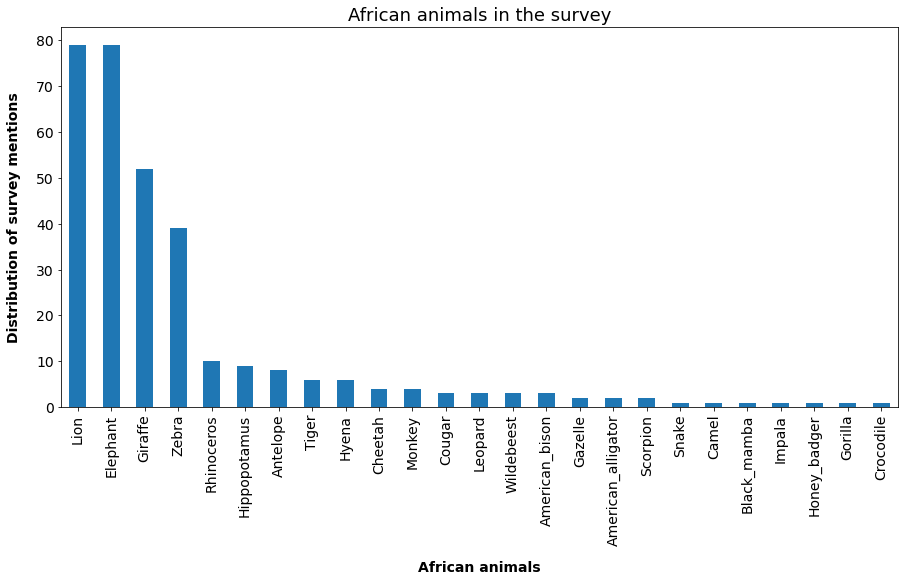

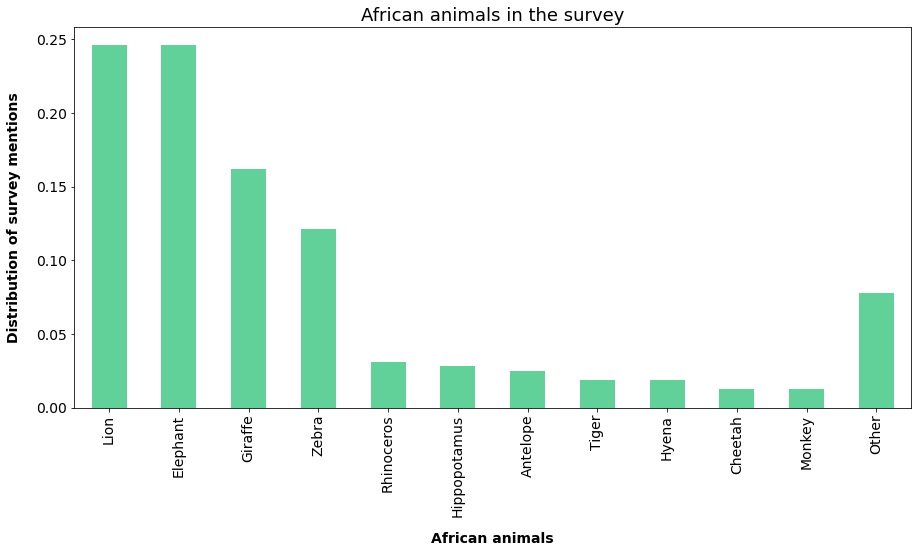

Normal distribution: African animals
----------------------------------
NormaltestResult(statistic=22.70488884466751, pvalue=1.1740755155532872e-05)
KstestResult(statistic=0.5012428088321544, pvalue=2.462757633655699e-06) [Kolmogorov-Smirnov-Test]
Lion                  0.246106
Elephant              0.246106
Giraffe               0.161994
Zebra                 0.121495
Rhinoceros            0.031153
Hippopotamus          0.028037
Antelope              0.024922
Tiger                 0.018692
Hyena                 0.018692
Cheetah               0.012461
Monkey                0.012461
Cougar                0.009346
Leopard               0.009346
Wildebeest            0.009346
American_bison        0.009346
Gazelle               0.006231
American_alligator    0.006231
Scorpion              0.006231
Snake                 0.003115
Camel                 0.003115
Black_mamba           0.003115
Impala                0.003115
Honey_badger          0.003115
Gorilla               0.003115
Crocodil

In [33]:
evaluateCat(df_african_animals, 'African animals')

## Furniture

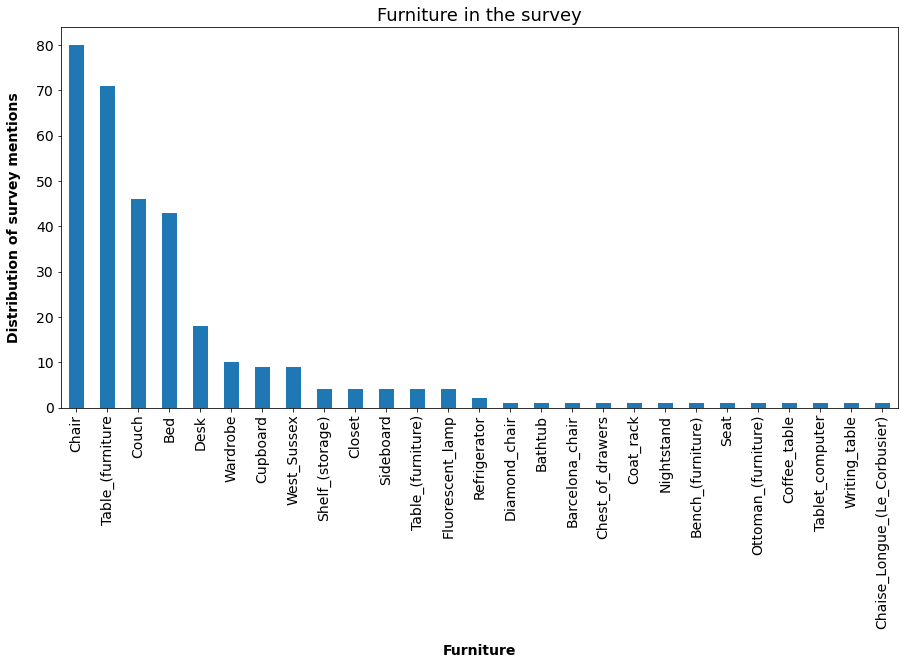

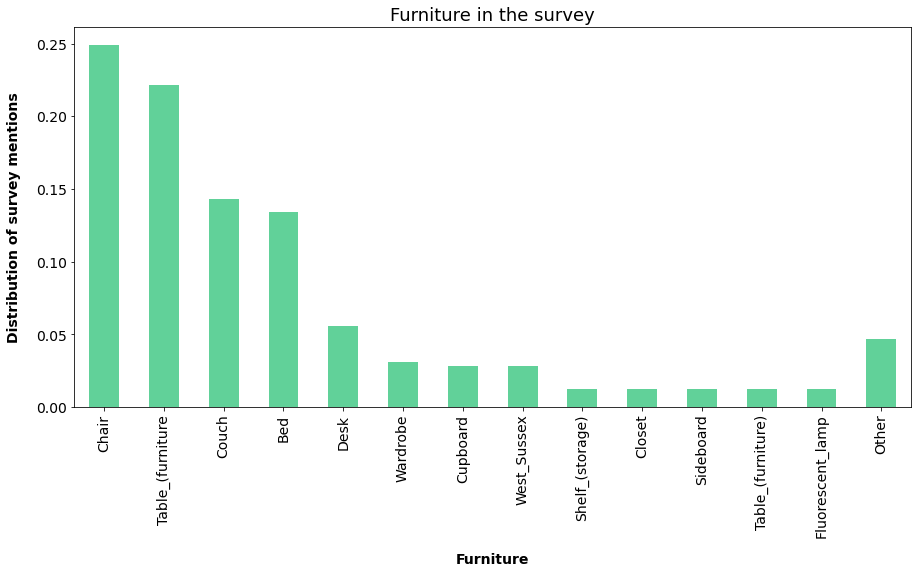

Normal distribution: Furniture
----------------------------------
NormaltestResult(statistic=24.594094877972378, pvalue=4.56520362605205e-06)
KstestResult(statistic=0.5012428088321544, pvalue=8.444395963071948e-07) [Kolmogorov-Smirnov-Test]
Chair                           0.249221
Table_(furniture                0.221184
Couch                           0.143302
Bed                             0.133956
Desk                            0.056075
Wardrobe                        0.031153
Cupboard                        0.028037
West_Sussex                     0.028037
Shelf_(storage)                 0.012461
Closet                          0.012461
Sideboard                       0.012461
Table_(furniture)               0.012461
Fluorescent_lamp                0.012461
Refrigerator                    0.006231
Diamond_chair                   0.003115
Bathtub                         0.003115
Barcelona_chair                 0.003115
Chest_of_drawers                0.003115
Coat_rack            

In [34]:
evaluateCat(df_furniture, 'Furniture')

## Vegetables

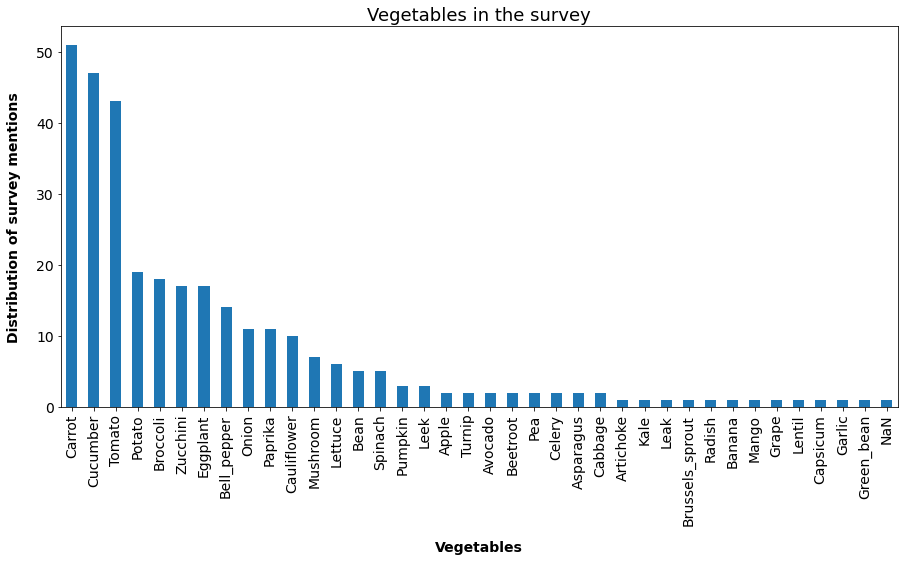

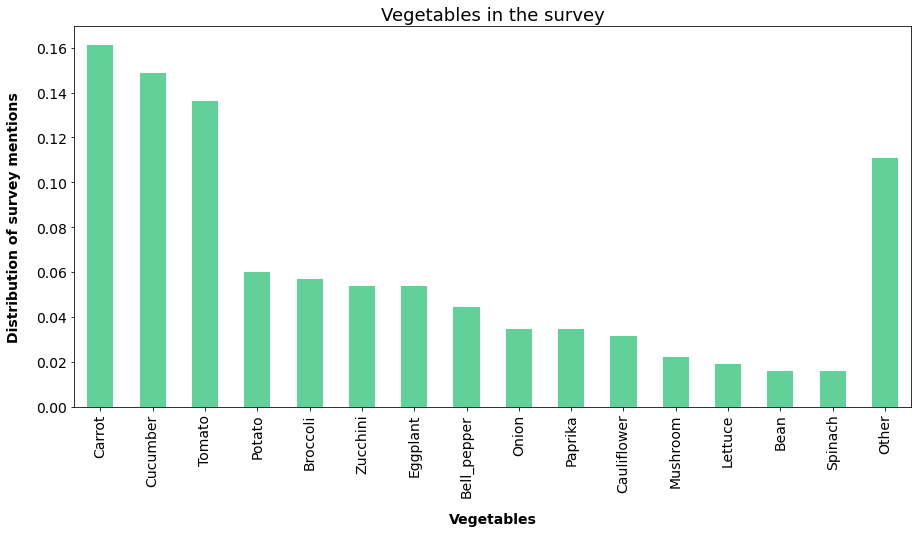

Normal distribution: Vegetables
----------------------------------
NormaltestResult(statistic=32.009712910794725, pvalue=1.1198997759690067e-07)
KstestResult(statistic=0.5012624734637335, pvalue=2.3399447894403413e-09) [Kolmogorov-Smirnov-Test]
Carrot             0.161392
Cucumber           0.148734
Tomato             0.136076
Potato             0.060127
Broccoli           0.056962
Zucchini           0.053797
Eggplant           0.053797
Bell_pepper        0.044304
Onion              0.034810
Paprika            0.034810
Cauliflower        0.031646
Mushroom           0.022152
Lettuce            0.018987
Bean               0.015823
Spinach            0.015823
Pumpkin            0.009494
Leek               0.009494
Apple              0.006329
Turnip             0.006329
Avocado            0.006329
Beetroot           0.006329
Pea                0.006329
Celery             0.006329
Asparagus          0.006329
Cabbage            0.006329
Artichoke          0.003165
Kale               0.003165

In [35]:
evaluateCat(df_vegetables, 'Vegetables')

## Fast food

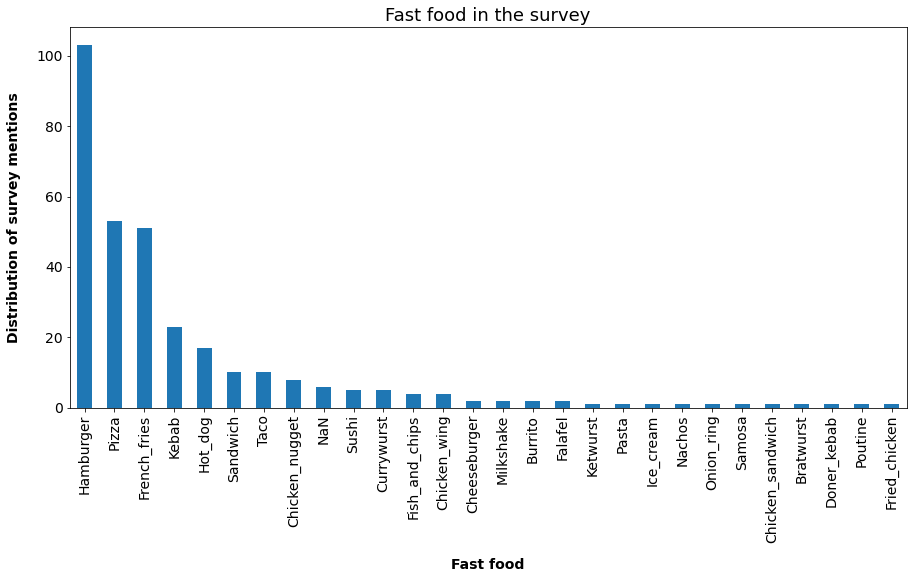

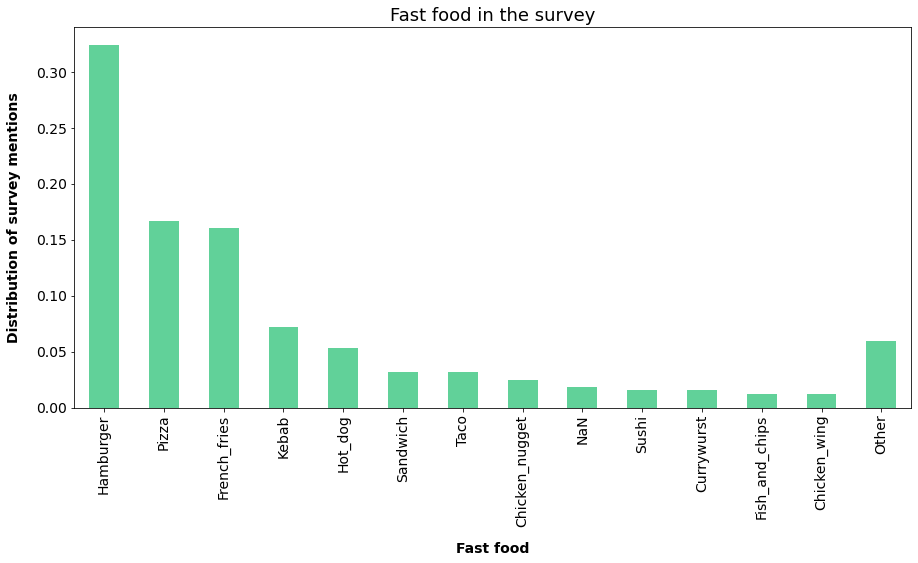

Normal distribution: Fast food
----------------------------------
NormaltestResult(statistic=40.181111824536714, pvalue=1.8827056630374354e-09)
KstestResult(statistic=0.5012545334053115, pvalue=4.94102239690406e-07) [Kolmogorov-Smirnov-Test]
Hamburger           0.323899
Pizza               0.166667
French_fries        0.160377
Kebab               0.072327
Hot_dog             0.053459
Sandwich            0.031447
Taco                0.031447
Chicken_nugget      0.025157
NaN                 0.018868
Sushi               0.015723
Currywurst          0.015723
Fish_and_chips      0.012579
Chicken_wing        0.012579
Cheeseburger        0.006289
Milkshake           0.006289
Burrito             0.006289
Falafel             0.006289
Ketwurst            0.003145
Pasta               0.003145
Ice_cream           0.003145
Nachos              0.003145
Onion_ring          0.003145
Samosa              0.003145
Chicken_sandwich    0.003145
Bratwurst           0.003145
Doner_kebab         0.003145
Pout

In [36]:
evaluateCat(df_fastfood, 'Fast food')

## European landmarks

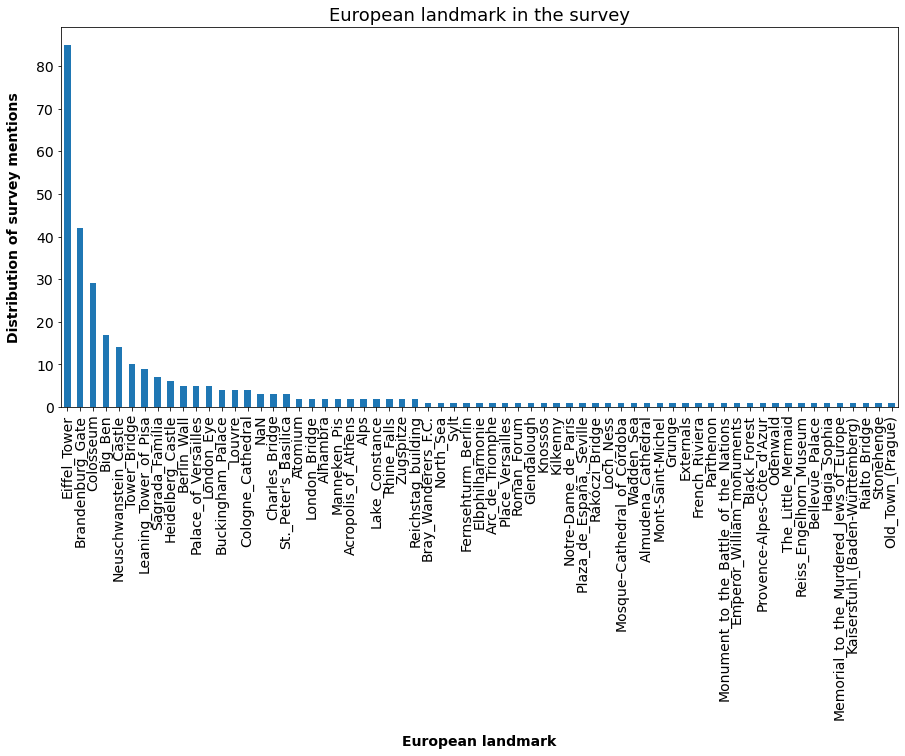

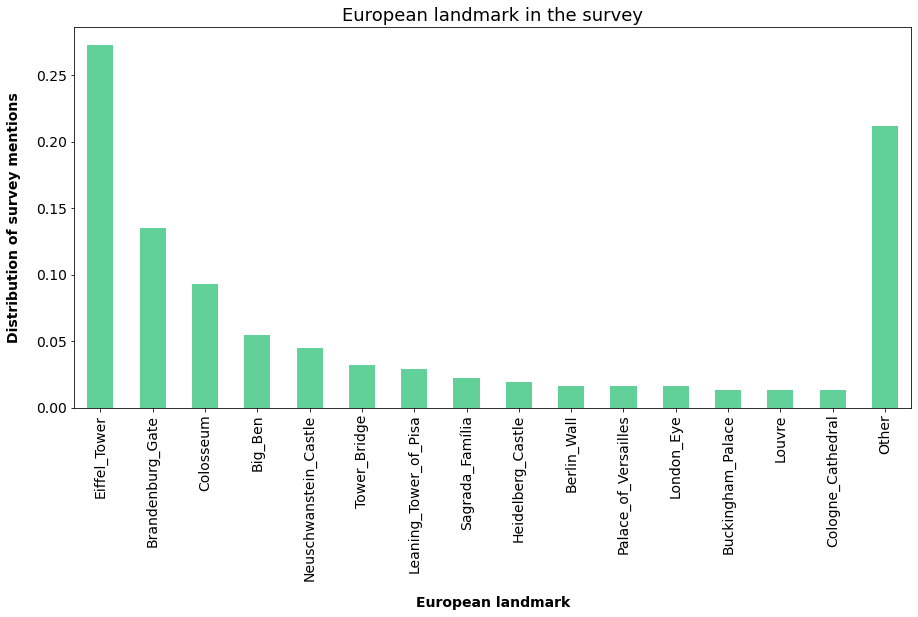

Normal distribution: European landmark
----------------------------------
NormaltestResult(statistic=107.87726515512803, pvalue=3.75620693480945e-24)
KstestResult(statistic=0.5012786589658879, pvalue=1.2373638950629992e-15) [Kolmogorov-Smirnov-Test]
Eiffel_Tower                               0.272436
Brandenburg_Gate                           0.134615
Colosseum                                  0.092949
Big_Ben                                    0.054487
Neuschwanstein_Castle                      0.044872
                                             ...   
Memorial_to_the_Murdered_Jews_of_Europe    0.003205
Kaiserstuhl_(Baden-Württemberg)            0.003205
Rialto_Bridge                              0.003205
Stonehenge                                 0.003205
Old_Town_(Prague)                          0.003205
Name: r_name, Length: 65, dtype: float64
Dataframe shape is (65,)
----------------------------------------
df Kurtosis: 29.744526865477106
df Skewness: 5.2235681795541264


In [37]:
evaluateCat(df_european_landmarks, 'European landmark')

## DAX companies

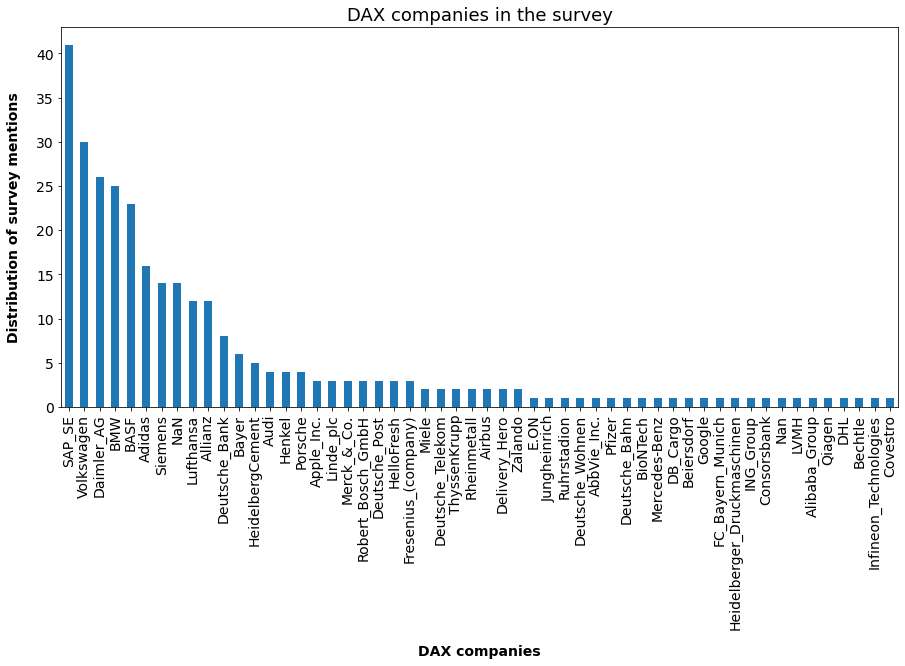

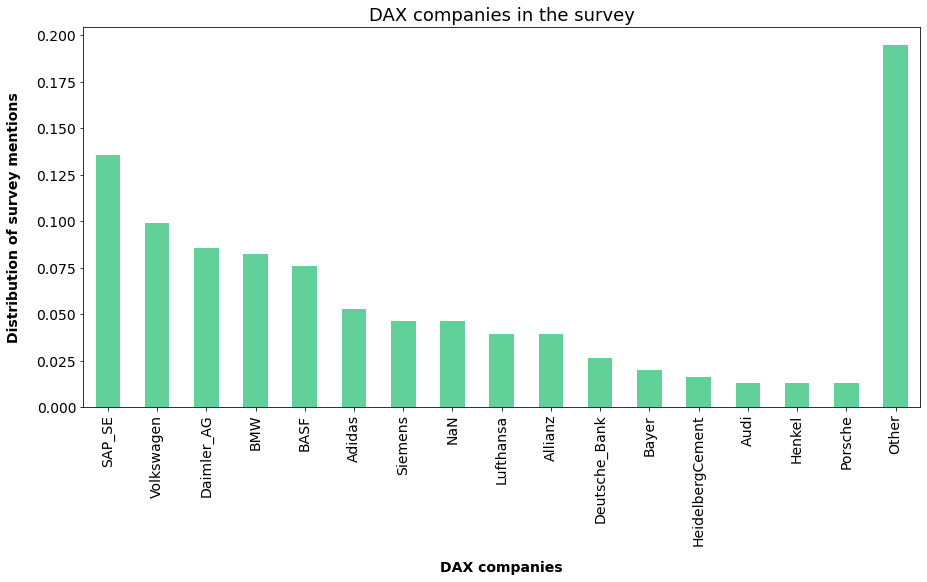

Normal distribution: DAX companies
----------------------------------
NormaltestResult(statistic=42.16005878269325, pvalue=6.99937975425017e-10)
KstestResult(statistic=0.5013166387992658, pvalue=4.439826111631906e-13) [Kolmogorov-Smirnov-Test]
SAP_SE                         0.135314
Volkswagen                     0.099010
Daimler_AG                     0.085809
BMW                            0.082508
BASF                           0.075908
Adidas                         0.052805
Siemens                        0.046205
NaN                            0.046205
Lufthansa                      0.039604
Allianz                        0.039604
Deutsche_Bank                  0.026403
Bayer                          0.019802
HeidelbergCement               0.016502
Audi                           0.013201
Henkel                         0.013201
Porsche                        0.013201
Apple_Inc.                     0.009901
Linde_plc                      0.009901
Merck_&_Co.                    0.009

In [38]:
evaluateCat(df_dax_companies, 'DAX companies')

## European countries

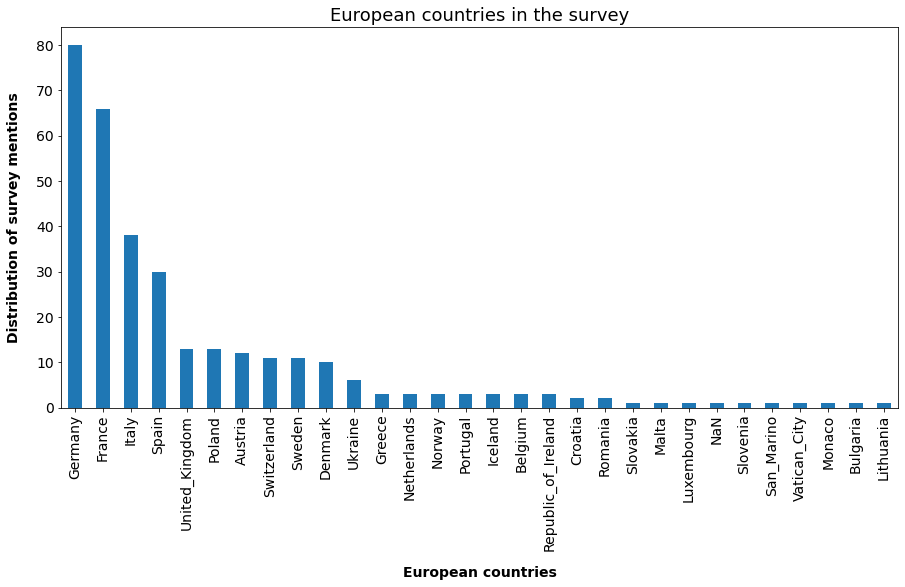

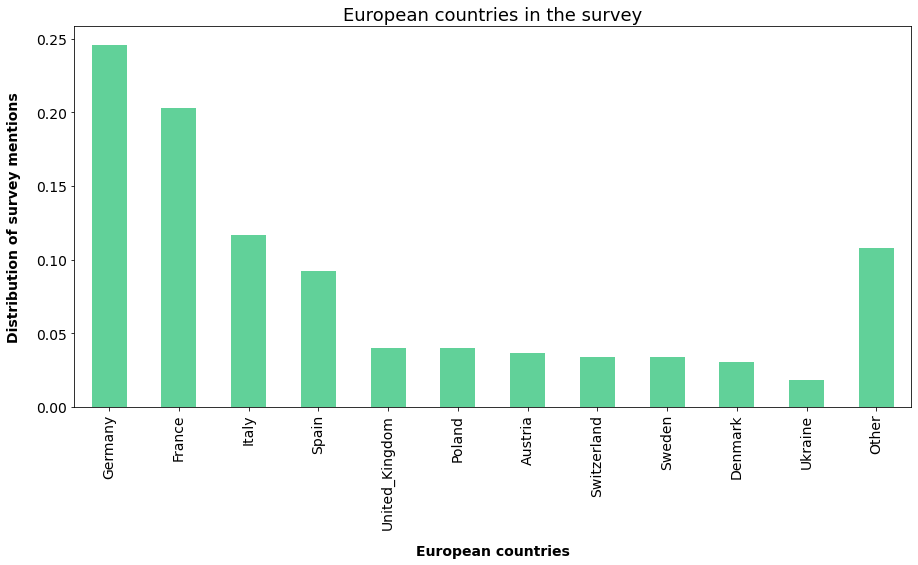

Normal distribution: European countries
----------------------------------
NormaltestResult(statistic=34.27436418555041, pvalue=3.6092451515150084e-08)
KstestResult(statistic=0.5012275127720234, pvalue=1.697290232324343e-07) [Kolmogorov-Smirnov-Test]
Germany                0.246154
France                 0.203077
Italy                  0.116923
Spain                  0.092308
United_Kingdom         0.040000
Poland                 0.040000
Austria                0.036923
Switzerland            0.033846
Sweden                 0.033846
Denmark                0.030769
Ukraine                0.018462
Greece                 0.009231
Netherlands            0.009231
Norway                 0.009231
Portugal               0.009231
Iceland                0.009231
Belgium                0.009231
Republic_of_Ireland    0.009231
Croatia                0.006154
Romania                0.006154
Slovakia               0.003077
Malta                  0.003077
Luxembourg             0.003077
NaN          

In [39]:
evaluateCat(df_european_countries, 'European countries')

## US Companies

/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 142 (\x8e) missing from current font.
  if sys.path[0] == '':


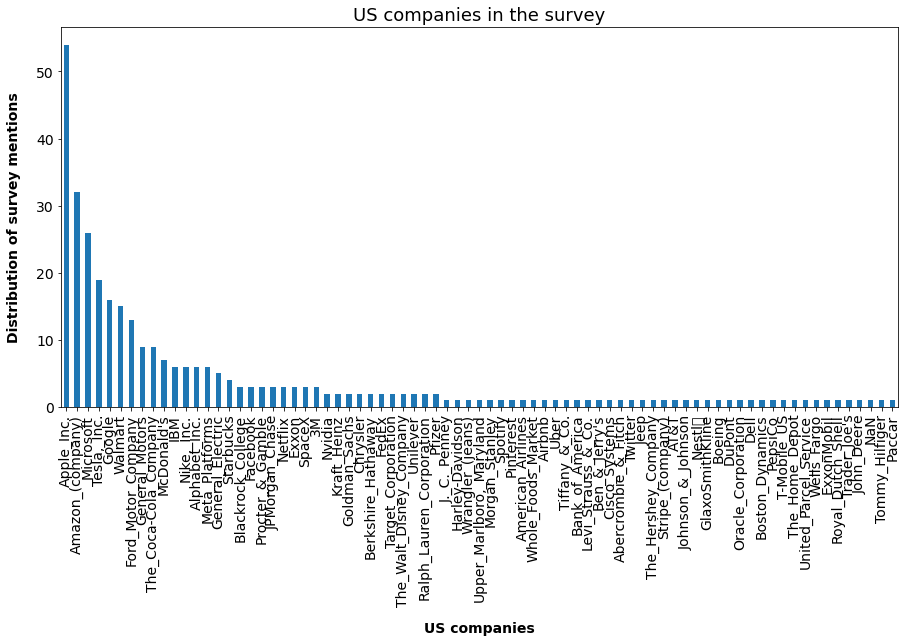

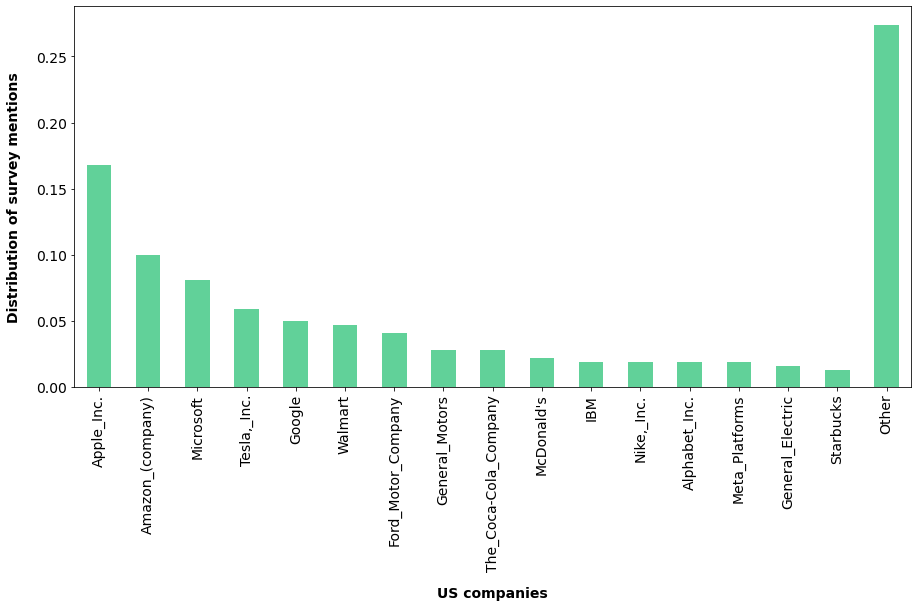

Normal distribution: US companies
----------------------------------
NormaltestResult(statistic=100.87406611035706, pvalue=1.2458761167841497e-22)
KstestResult(statistic=0.5012428088321544, pvalue=2.0225569247098265e-18) [Kolmogorov-Smirnov-Test]
Apple_Inc.          0.168224
Amazon_(company)    0.099688
Microsoft           0.080997
Tesla,_Inc.         0.059190
Google              0.049844
                      ...   
Trader_Joe's        0.003115
John_Deere          0.003115
NaN                 0.003115
Tommy_Hilfiger      0.003115
Paccar              0.003115
Name: r_name, Length: 77, dtype: float64
Dataframe shape is (77,)
----------------------------------------
df Kurtosis: 20.266817696485038
df Skewness: 4.202192012648904


In [45]:
evaluateCat(df_us_companies, 'US companies')

## US Tech Companies

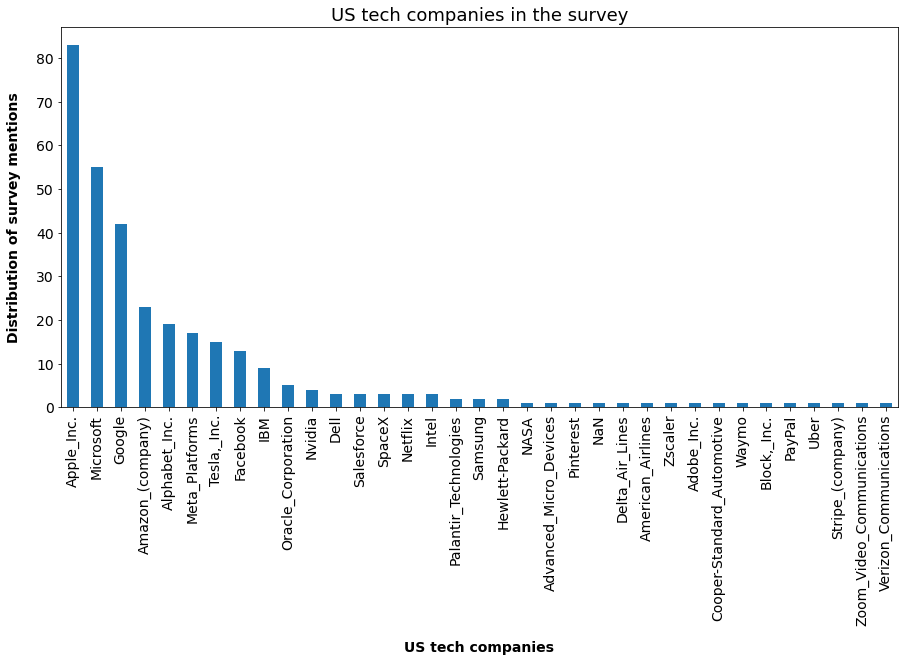

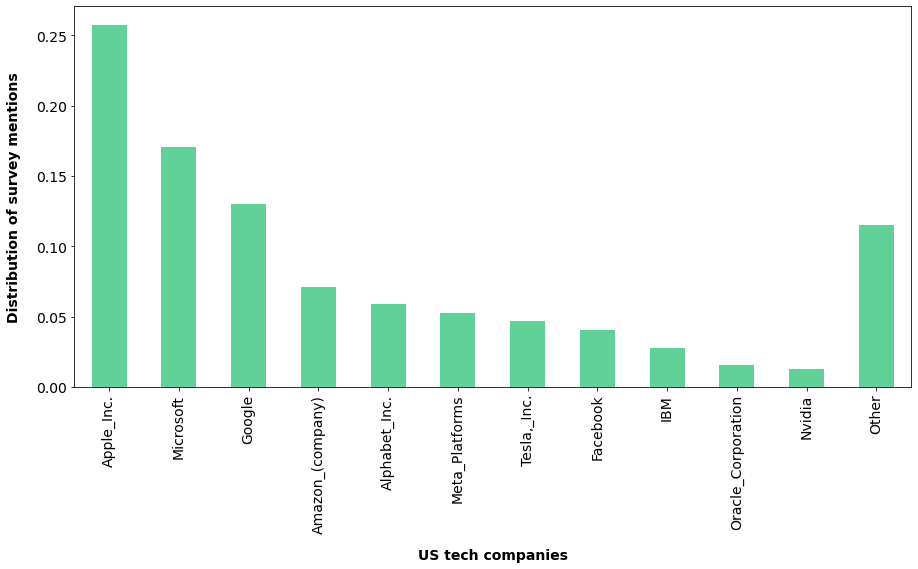

Normal distribution: US tech companies
----------------------------------
NormaltestResult(statistic=43.282317644927325, pvalue=3.9935961171199635e-10)
KstestResult(statistic=0.5012389491898238, pvalue=1.1677111008703717e-08) [Kolmogorov-Smirnov-Test]
Apple_Inc.                    0.257764
Microsoft                     0.170807
Google                        0.130435
Amazon_(company)              0.071429
Alphabet_Inc.                 0.059006
Meta_Platforms                0.052795
Tesla,_Inc.                   0.046584
Facebook                      0.040373
IBM                           0.027950
Oracle_Corporation            0.015528
Nvidia                        0.012422
Dell                          0.009317
Salesforce                    0.009317
SpaceX                        0.009317
Netflix                       0.009317
Intel                         0.009317
Palantir_Technologies         0.006211
Samsung                       0.006211
Hewlett-Packard               0.006211
NASA   

In [46]:
evaluateCat(df_us_tech_companies, 'US tech companies')